In [10]:
#env 로드
import os
import topogenesis as tg
import trimesh as tm
import numpy as np
import pyvista as pv
import panel as pn
import pandas as pd 
import copy

import ipywidgets as widgets
from ladybug.sunpath import Sunpath #ladybug sunpath 호출
from IPython.display import display, Image
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

# csv에서 lattice 배열 만드는 함수 정의
def lattice_from_csv(file_path):
    # 데이터를 읽어옴
    meta_df = pd.read_csv(file_path, nrows=3)
    # shape, unit, minbound 데이터를 배열로 변환
    shape = np.array(meta_df['shape'])       # 시작 좌표 [x_min, y_min, z_min] 예를 들어, [-55000, -7000, 0] x축 -55000, y축 -7000, z축 0의 위치
    unit = np.array(meta_df['unit'])         # 몇개의 셀로 구성되는지 [x_shape, y_shape, z_shape] 예를 들어 [56, 35, 24]이면 x축 56개, y 35개, z 24개의 셀을 가집니다.
    minbound = np.array(meta_df['minbound']) # 각 셀의 크기. 예를 들어, [1000, 1000, 3000] 각 셀의 크기는 x축 1000 단위, y축 1000 단위, z축 3000 단위
    # np.array는 csv에서 불러온 데이터를 배열로 변환하는데 사용 
    # 그리드 데이터를 읽어옴
    lattice_df = pd.read_csv(file_path, skiprows=5) # 앞의 5개 줄을 스킵하고 6개 부터 데이터를 불러오기
    # 데이터의 'value' 열을 배열로 변환한 후 이를 'shape' 배열에 맞게 재구성 
    buffer = np.array(lattice_df['value']).reshape(shape)
    # lattice를 토포제네시스에서 재구성 buffer는 배열에 맞는 value값. 
    l = tg.to_lattice(buffer, minbound=minbound, unit=unit)
    
    return l

# tri_to_pv 함수 정의: 삼각형 메시(tri_mesh)를 PyVista 형식으로 변환합니다.
def tri_to_pv(tri_mesh):
    #  tri_mesh.faces 배열에 각 face의 시작 부분에 3을 추가하여 새로운 배열을 만듭니다.
    # 'constant' 모드로 패딩을 추가하여 각 face의 시작에 3을 삽입합니다.
    faces = np.pad(tri_mesh.faces, ((0, 0), (1, 0)), 'constant', constant_values=3)
    # PyVista의 PolyData 객체를 생성하여, tri_mesh의 정점(vertices)과 패딩된 faces 배열을 사용합니다.
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)    
    # 변환된 PyVista 메쉬 객체를 반환합니다.
    return pv_mesh

# 1이라는 범위에 대한 이웃패턴 정의 (중심을 포함함)
stencil = tg.create_stencil("von_neumann", 1, 1)
# 중심을 인덱스 비활성화 - [0,0,0]을 0으로 세팅함으로 중심을 패턴 비활성화
stencil.set_index([0,0,0], 0)


In [11]:
#csv 로드
csv_path = os.path.relpath('original_lattice/interior_lattice.csv')
#obj 포인트 csv 로드
context_mesh = tm.load(os.path.relpath('obj\context.obj'))  # 주변환경 obj 메시 불러오기
street_pc = tg.cloud_from_csv("pts\pts_str(11).CSV")        # street point as csv (포인트를 csv로 저장) 
entrance_pc = tg.cloud_from_csv("pts\ent_pts01.CSV")        # entrance point as csv (라이노 포인트를 csv로 저장)
envelope_lattice = tg.lattice_from_csv(csv_path)

avail_lattice = tg.lattice_from_csv(csv_path)                                         # CSV 파일에서 격자 데이터 불러오기
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)             # 복사된 데이터를 격자 객체로 변환

In [12]:
# 'excel/program (이노션).xlsx' 파일에서 'Sheet1' 시트를 읽어옴
df = pd.read_excel('excel/program (이노션).xlsx', sheet_name='Sheet1')
program_prefs = df[['sun_acc', 'ent_acc', 'str_acc', 'ung_pre', 'dist_facade','top_pre']].copy()

# 인덱스를 재설정(기존 index를 버리고 새로운 인덱스로) 0부터 숫자 인덱스를 생성
program_prefs.reset_index(drop=True, inplace=True)
fields = {}  # 필드를 저장할 빈 딕셔너리를 생성

for f in program_prefs.columns:  # 각 필드에 대한 파일 경로 설정    
    lattice_path = os.path.relpath('matrixs/' + f + '.csv')      
    try:        
        fields[f] = tg.lattice_from_csv(lattice_path)  # 배열 파일에서 데이터를 불러와서 fields 딕셔너리에 저장
    except:        
        fields[f] = copy.deepcopy(avail_lattice * 0 + 1)# 파일이 없을 경우, 모든 값을 1로 설정한 기본 격자 데이터를 fields 딕셔너리에 저장


top_pre_index = df.columns.get_loc('top_pre') # 'top_pre' 열의 인덱스 찾기 (5번째에 위치)
program_mtx = df.iloc[:, top_pre_index + 1:]  # 'top_pre' 열 이후 모든 열을 포함하는 새로운 데이터프레임 생성 (프로그램 상관관계 matrix 찾기)
program_mtx.columns = range(len(program_mtx.columns)) # 새로운 데이터프레임의 열 이름을 0부터 시작하는 숫자로 변경     (프로그램 번호입력 0~ ) 

space_list = df['space_name'].to_dict() # 'space_name' 열을 딕셔너리로 변환하여 'space_list'에 저장
sizes_complete = df['vox_amount']# 'vox_amount' 열의 값을 가져와 'sizes_complete'에 저장

agent_areas = [] # 'agent_areas' 리스트 초기화

for area in sizes_complete: # 'sizes_complete'의 각 값에 대해 반복 
    agent_areas.append(round(int(area)))    # 각 값을 정수로 변환하고 반올림하여 'agent_areas'에 추가

# print(space_list)   # 변환된 딕셔너리를 출력
# print(agent_areas)  # 'agent_areas' 리스트를 출력
# print(program_prefs)
# print(program_mtx)

In [13]:
agn_num = space_list
print (agn_num)

{0: 'Lobby', 1: 'Branding Space', 2: 'External Contact', 3: 'Interview Room', 4: 'Personal Workspace', 5: 'Work Support Area', 6: 'Personal Locker Room', 7: 'Executive Space', 8: 'VIP Reception', 9: 'Secretary Room', 10: 'Pantry', 11: 'Executive Meeting', 12: 'Executive Offices', 13: 'Focus Rooms', 14: 'Project Rooms', 15: 'Conference Rooms', 16: '4-Person Meeting', 17: '6-Person Meeting', 18: '8-Person Meeting', 19: '12-Person Meeting', 20: '18-Person Meeting', 21: 'Idea Room', 22: 'Mail Room', 23: 'Oasis', 24: 'PT Practice Room', 25: 'Screening Room', 26: 'Studio', 27: 'Video Editing', 28: 'Plotter/Board Room', 29: 'Training Room', 30: 'Ino Kitchen', 31: 'Kitchen', 32: 'Ino Cafe', 33: 'Fitness Facilities', 34: 'Dressing/Shower', 35: 'Counseling Room', 36: 'Personal Rest Room', 37: 'Sleeping Room', 38: 'Nursing Room', 39: 'Work Lounge', 40: 'Town Hall', 41: 'Seminar Room', 42: 'Library', 43: 'Social Space', 44: 'Outdoor Terrace', 45: "Driver's Waiting", 46: 'Server Room', 47: 'Cleanin

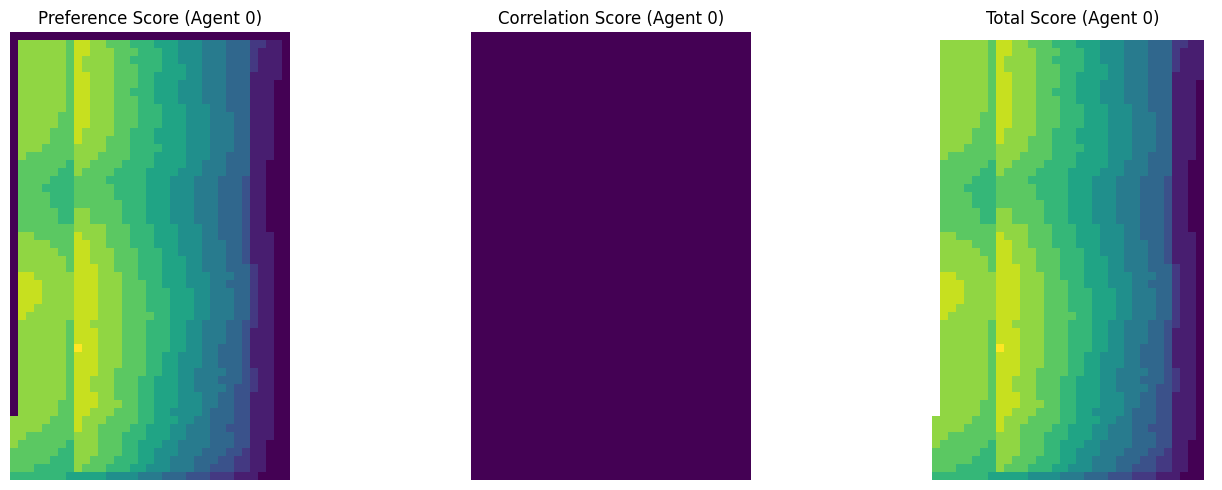

Agent 0:
Best location: (39, 8, 5)
Preference score at best location: 1.0000
Correlation score at best location: 0.0000
Total score at best location: 1.7000




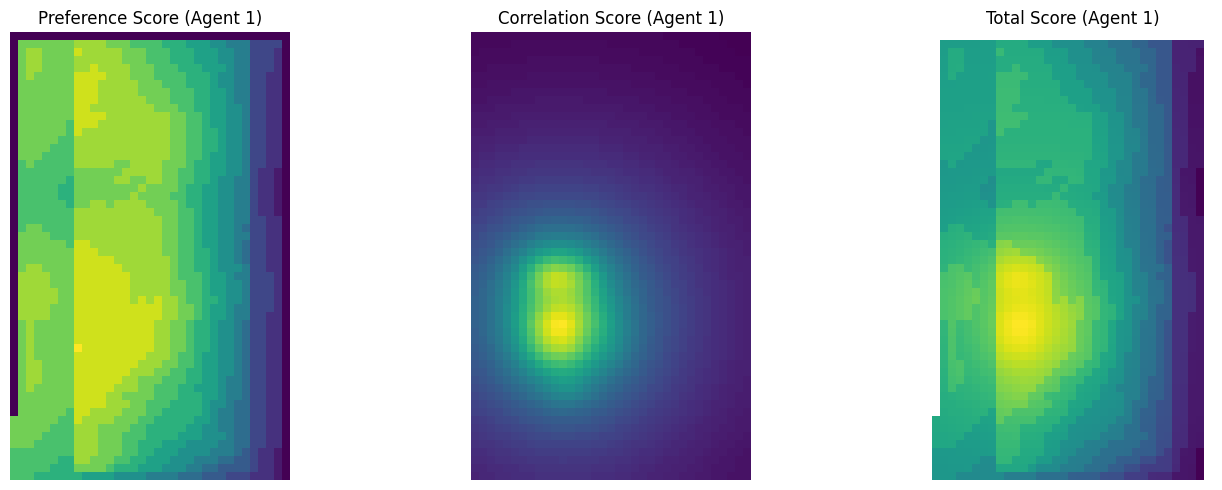

Agent 1:
Best location: (36, 11, 5)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




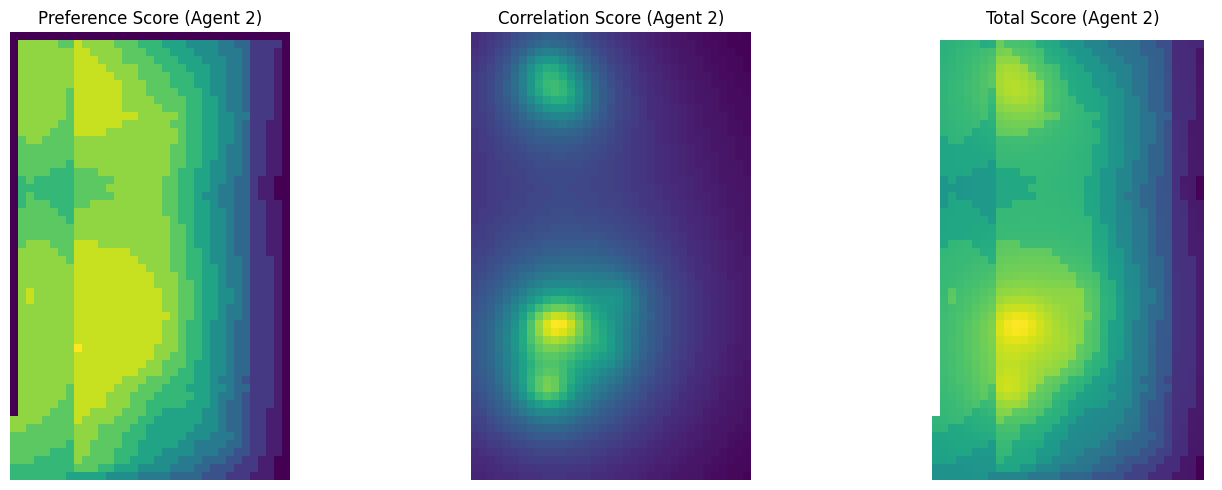

Agent 2:
Best location: (36, 10, 5)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




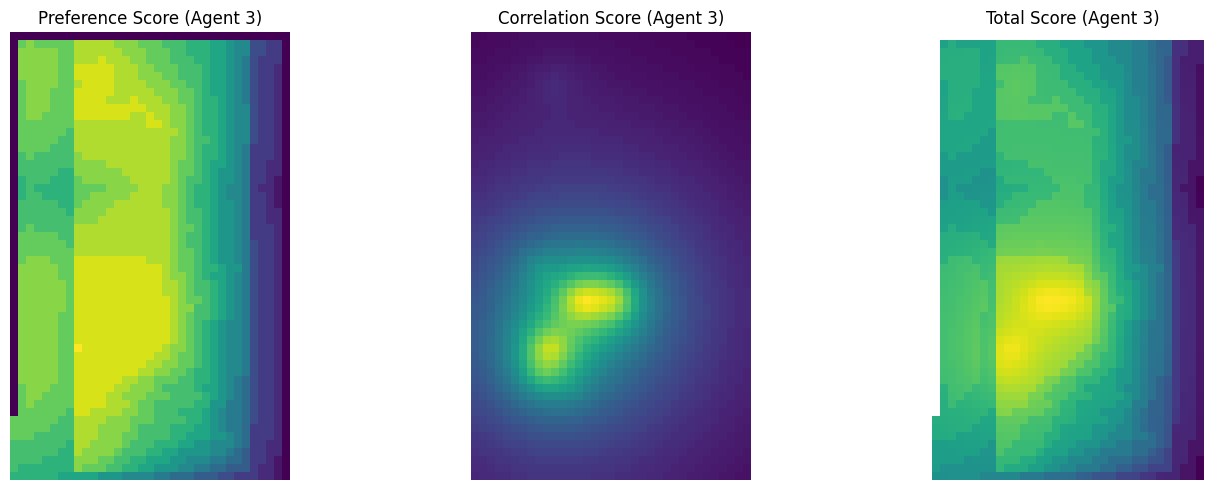

Agent 3:
Best location: (33, 14, 6)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




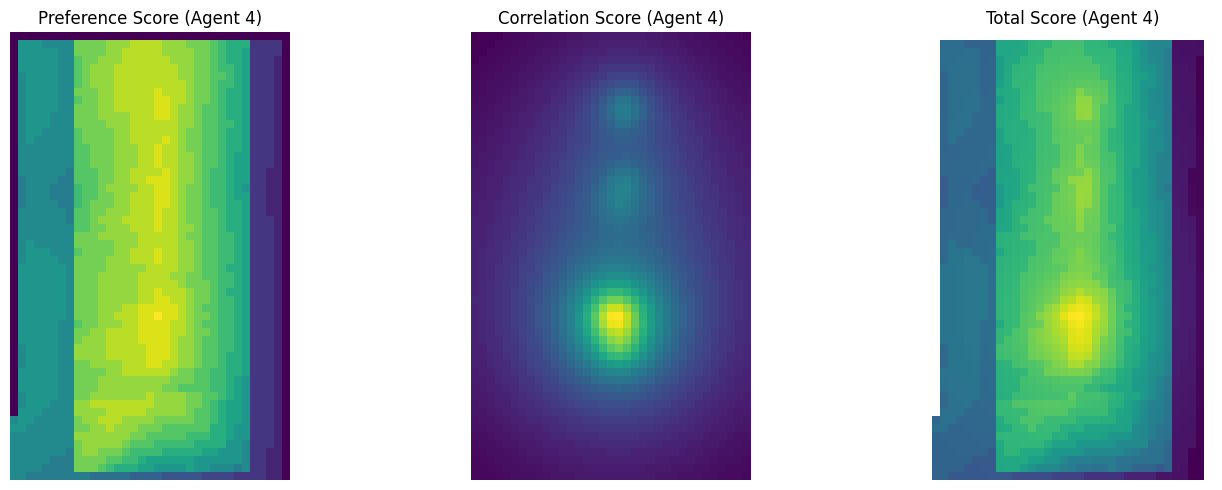

Agent 4:
Best location: (35, 18, 7)
Preference score at best location: 1.0000
Correlation score at best location: 0.8500
Total score at best location: 1.9550




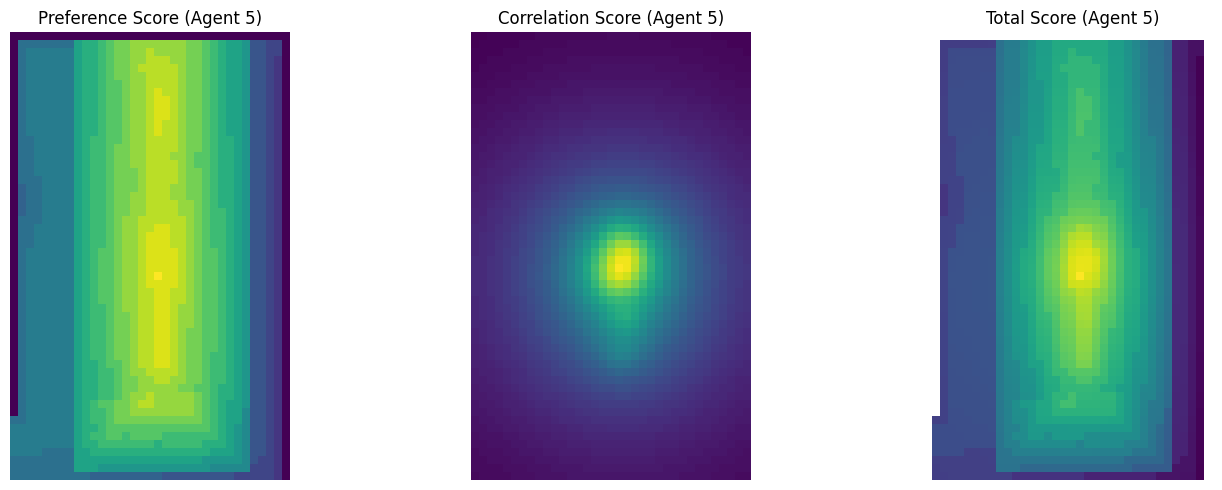

Agent 5:
Best location: (30, 18, 18)
Preference score at best location: 1.0000
Correlation score at best location: 0.9500
Total score at best location: 1.9850




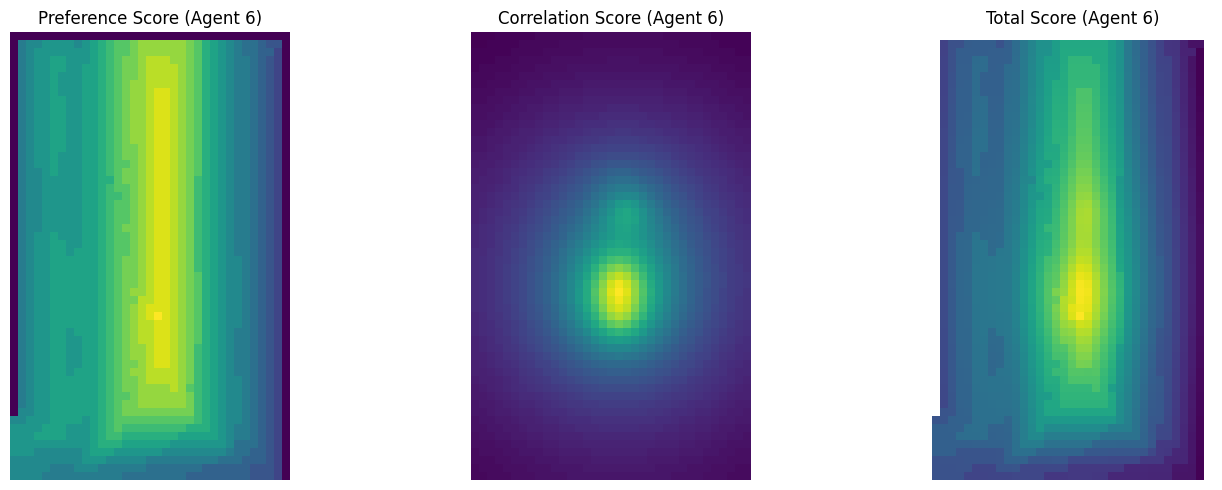

Agent 6:
Best location: (35, 18, 8)
Preference score at best location: 1.0000
Correlation score at best location: 0.8600
Total score at best location: 1.9580




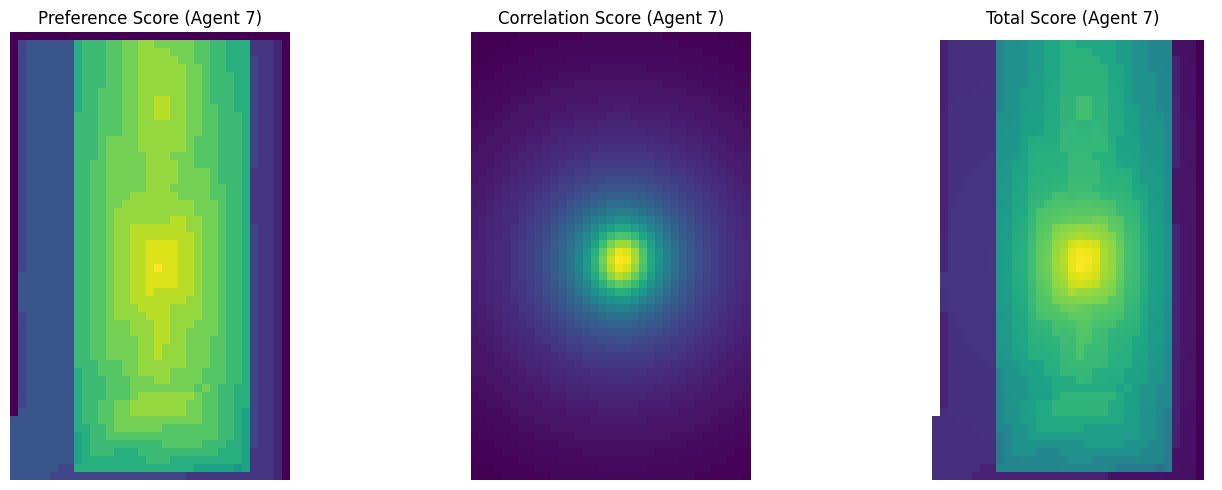

Agent 7:
Best location: (29, 18, 23)
Preference score at best location: 1.0000
Correlation score at best location: 0.8700
Total score at best location: 1.9610




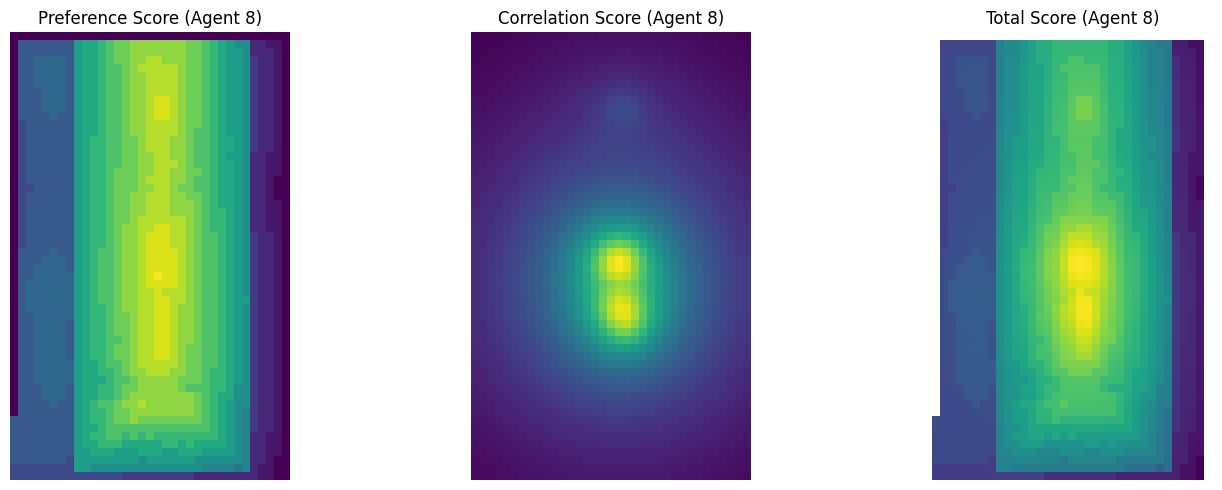

Agent 8:
Best location: (28, 18, 18)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




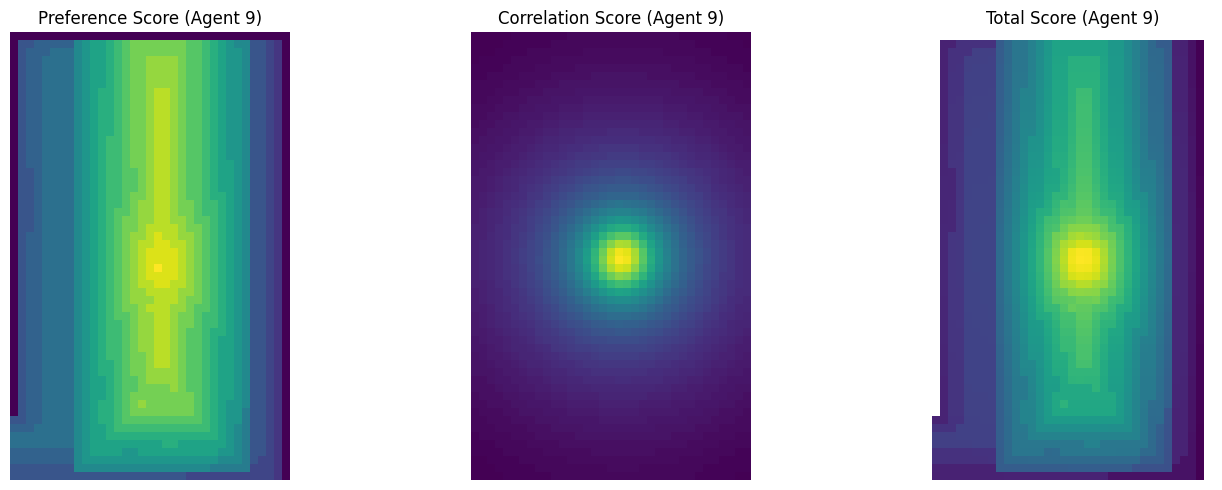

Agent 9:
Best location: (28, 18, 22)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




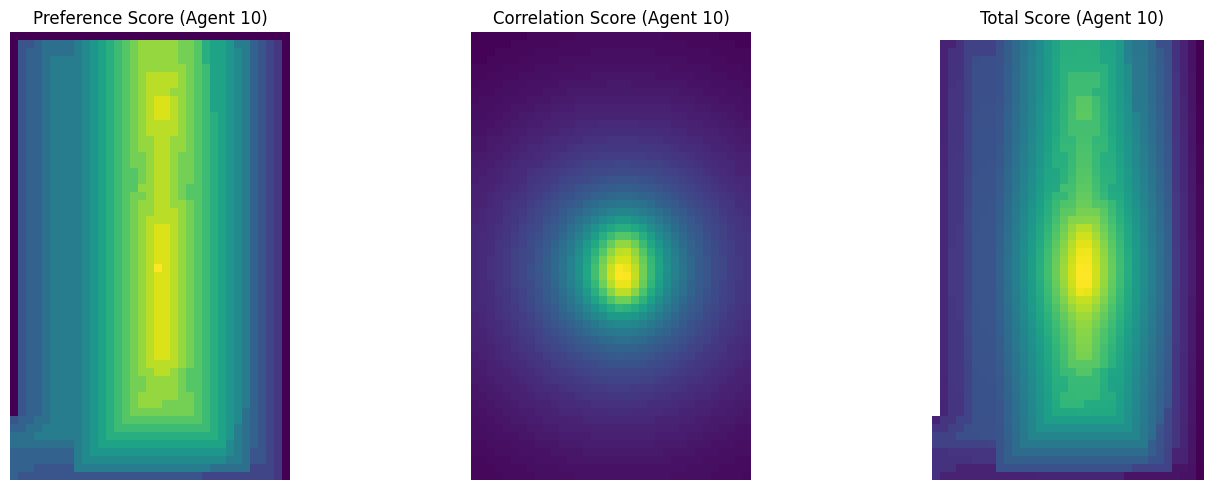

Agent 10:
Best location: (29, 18, 18)
Preference score at best location: 0.9500
Correlation score at best location: 0.9900
Total score at best location: 1.9470




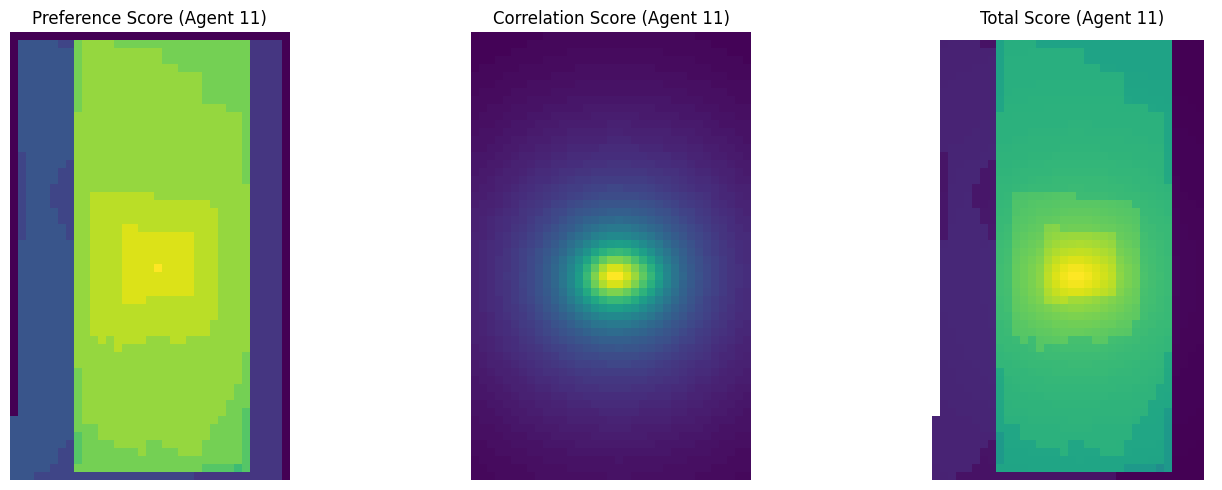

Agent 11:
Best location: (30, 17, 21)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




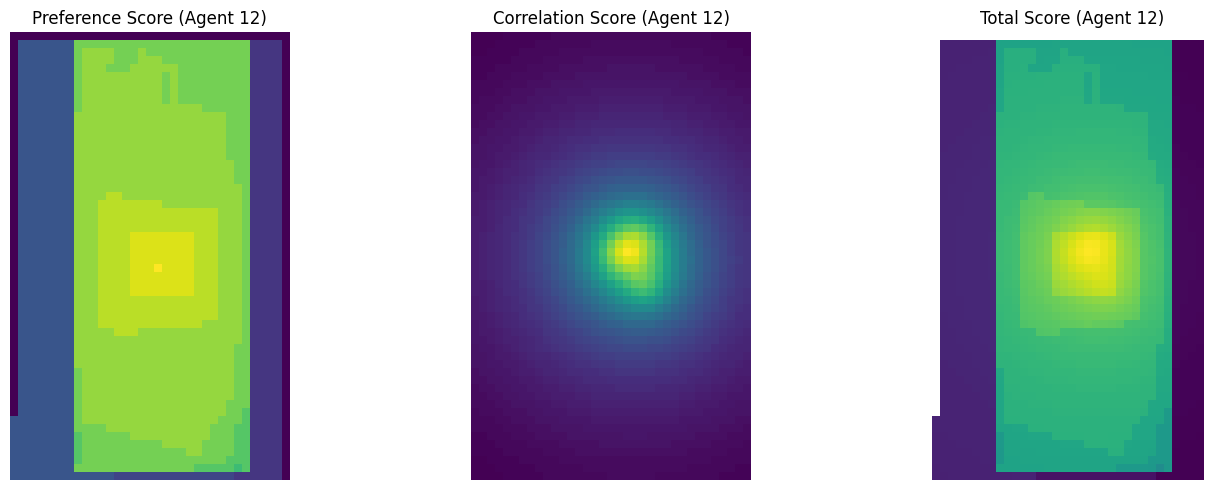

Agent 12:
Best location: (27, 19, 21)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




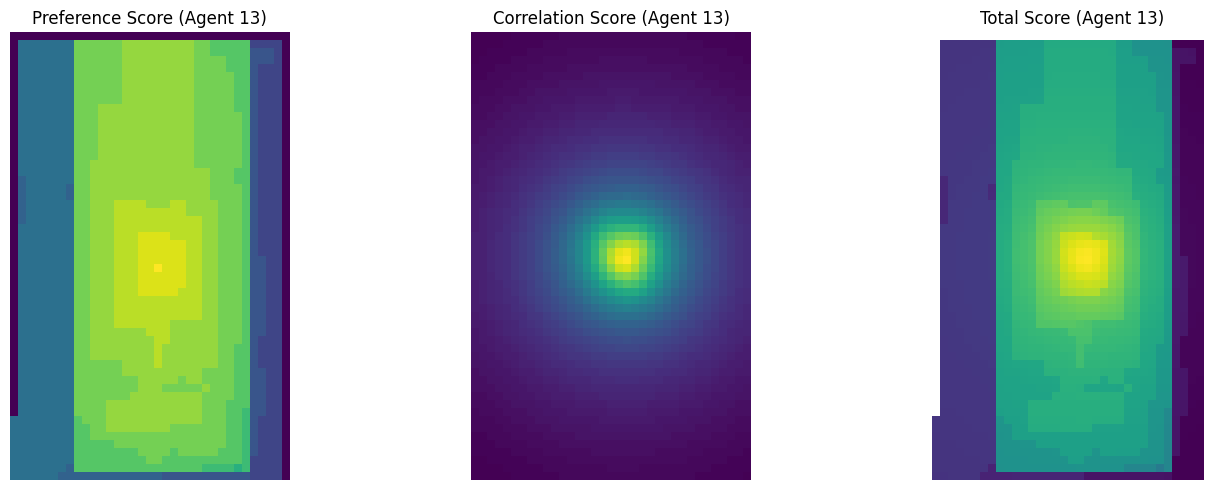

Agent 13:
Best location: (28, 19, 20)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




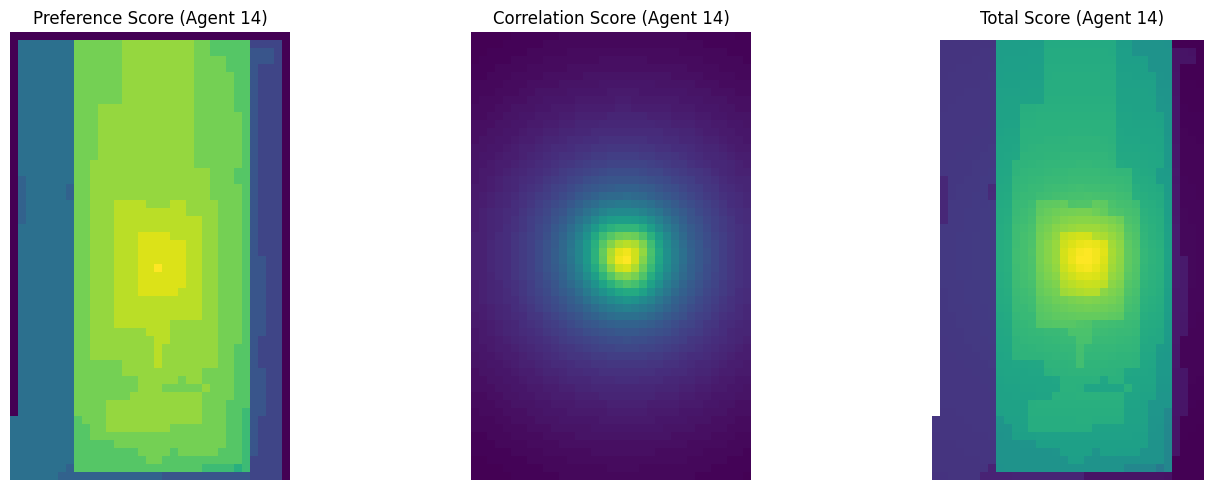

Agent 14:
Best location: (28, 19, 21)
Preference score at best location: 0.9500
Correlation score at best location: 0.9900
Total score at best location: 1.9470




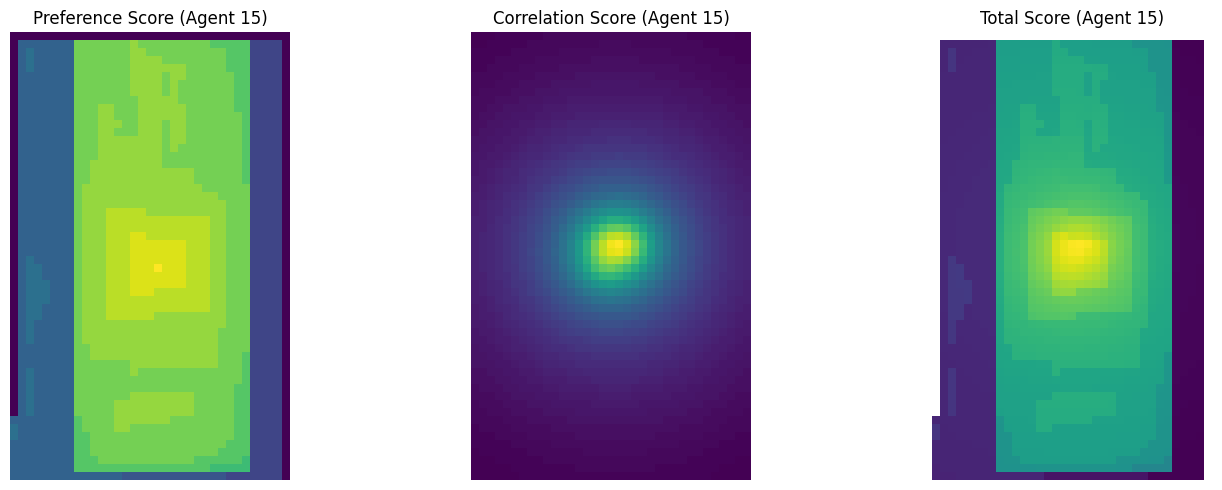

Agent 15:
Best location: (26, 18, 21)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




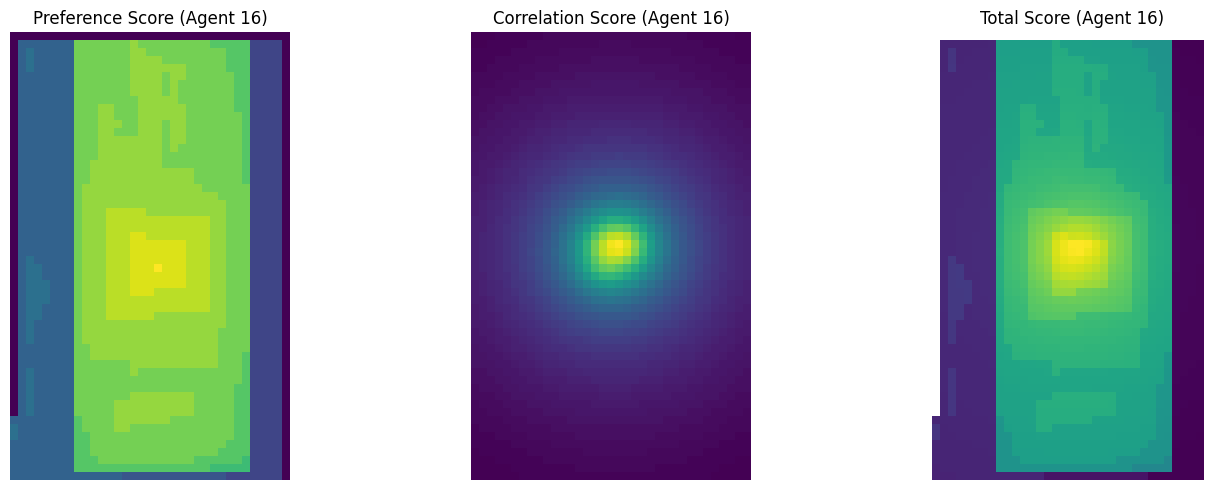

Agent 16:
Best location: (26, 17, 21)
Preference score at best location: 0.9500
Correlation score at best location: 0.9800
Total score at best location: 1.9440




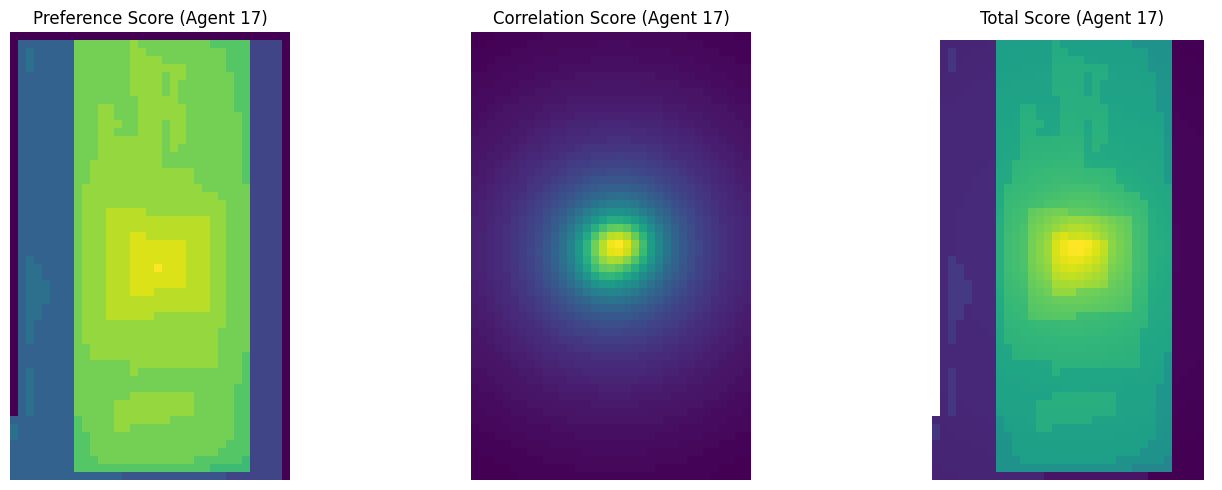

Agent 17:
Best location: (26, 18, 22)
Preference score at best location: 0.9500
Correlation score at best location: 0.9800
Total score at best location: 1.9440




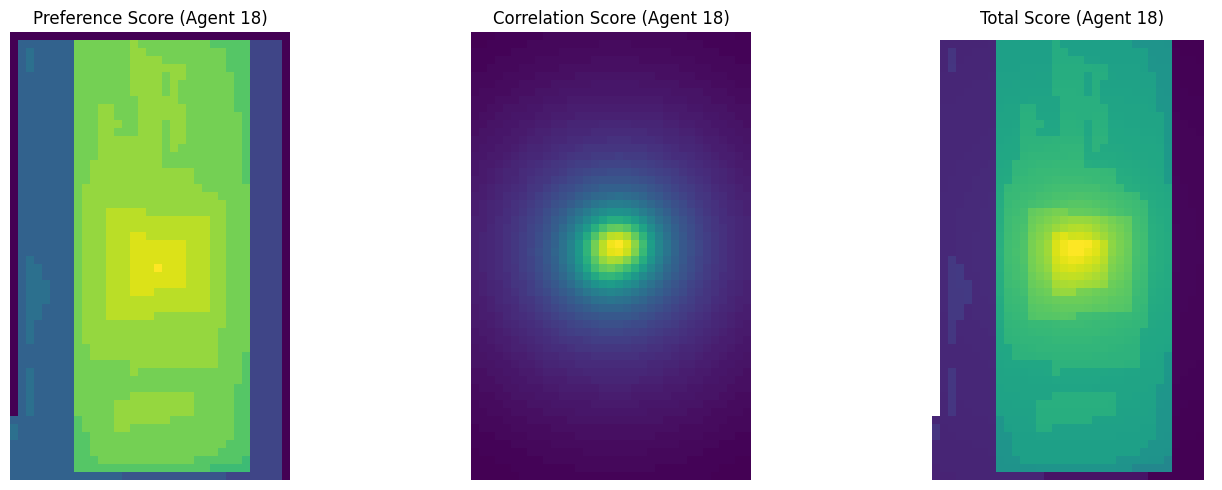

Agent 18:
Best location: (26, 17, 22)
Preference score at best location: 0.9500
Correlation score at best location: 0.9700
Total score at best location: 1.9410




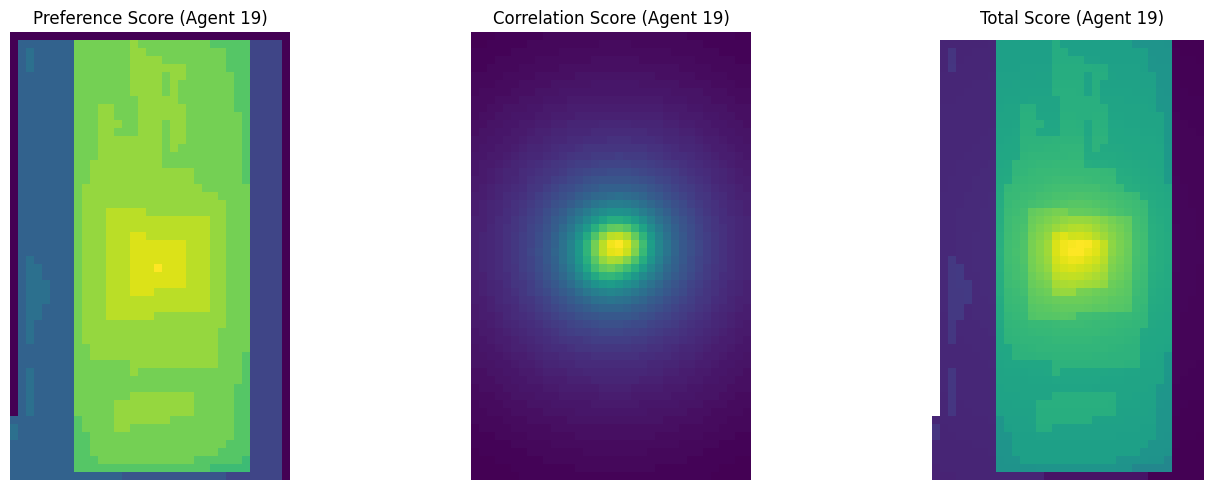

Agent 19:
Best location: (27, 18, 21)
Preference score at best location: 0.9500
Correlation score at best location: 0.9700
Total score at best location: 1.9410




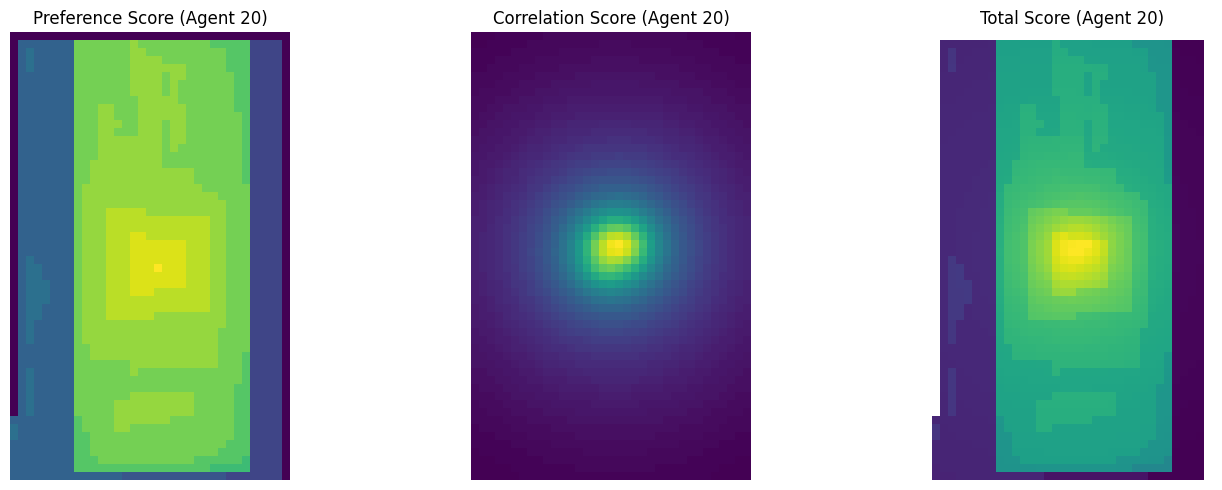

Agent 20:
Best location: (26, 18, 20)
Preference score at best location: 0.9500
Correlation score at best location: 0.9600
Total score at best location: 1.9380




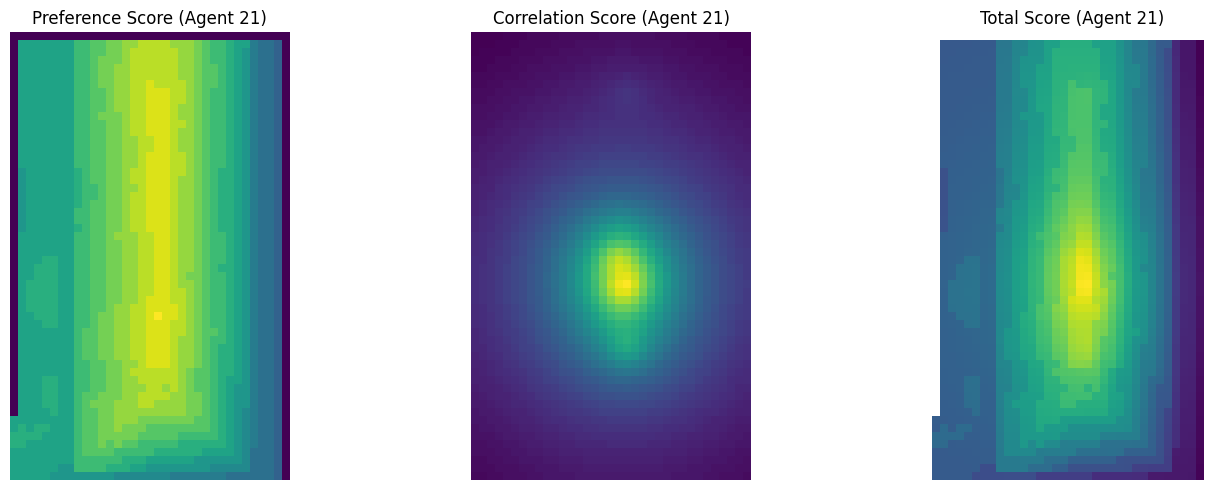

Agent 21:
Best location: (31, 19, 9)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




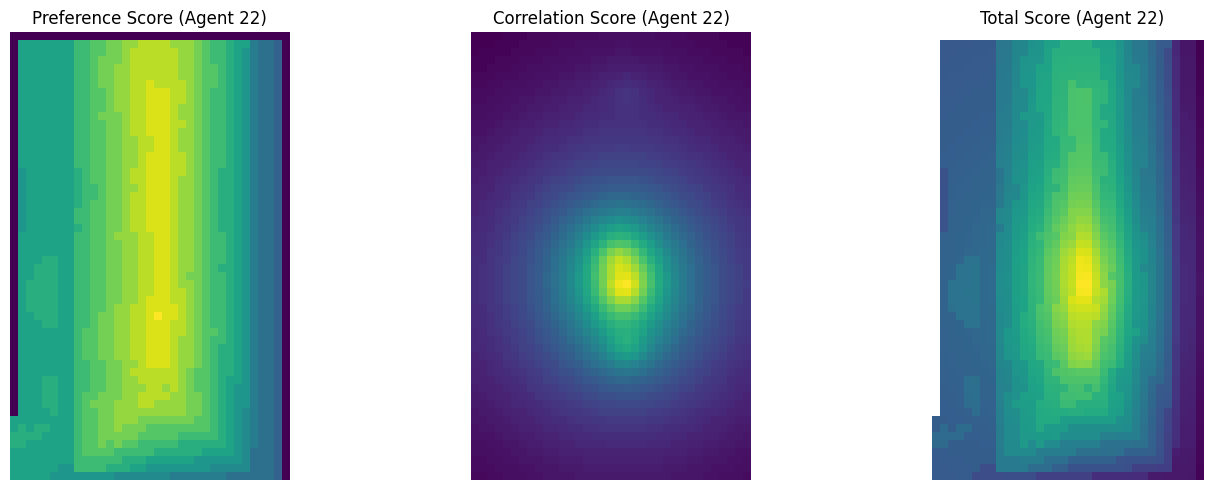

Agent 22:
Best location: (31, 19, 8)
Preference score at best location: 0.9500
Correlation score at best location: 0.9900
Total score at best location: 1.9470




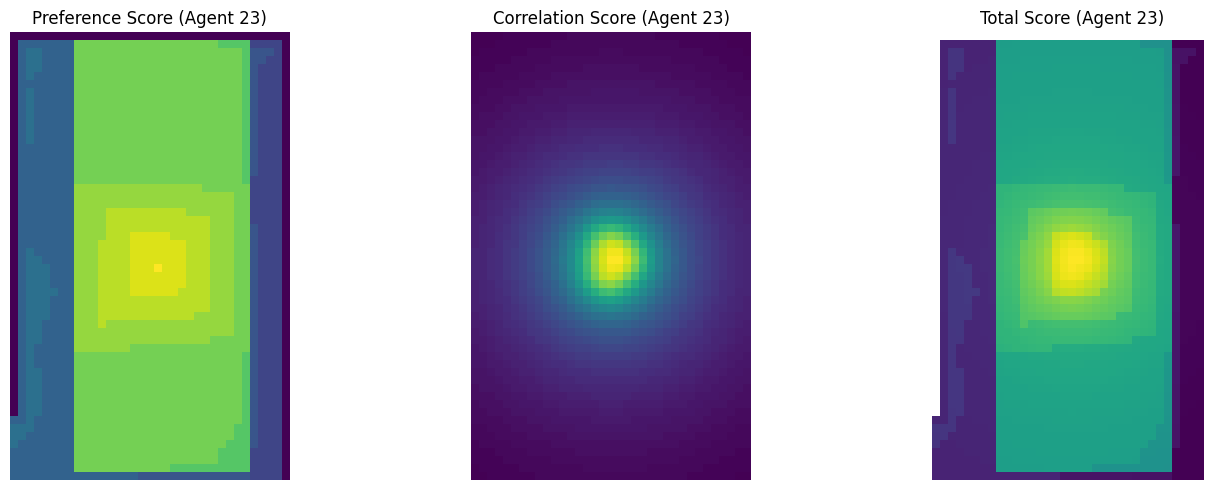

Agent 23:
Best location: (28, 17, 23)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




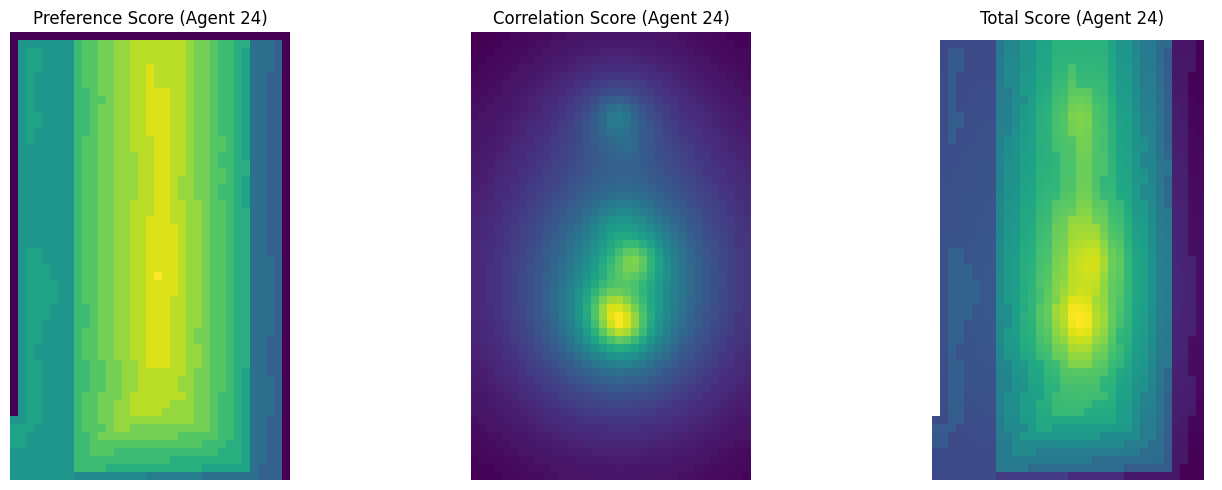

Agent 24:
Best location: (35, 18, 12)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




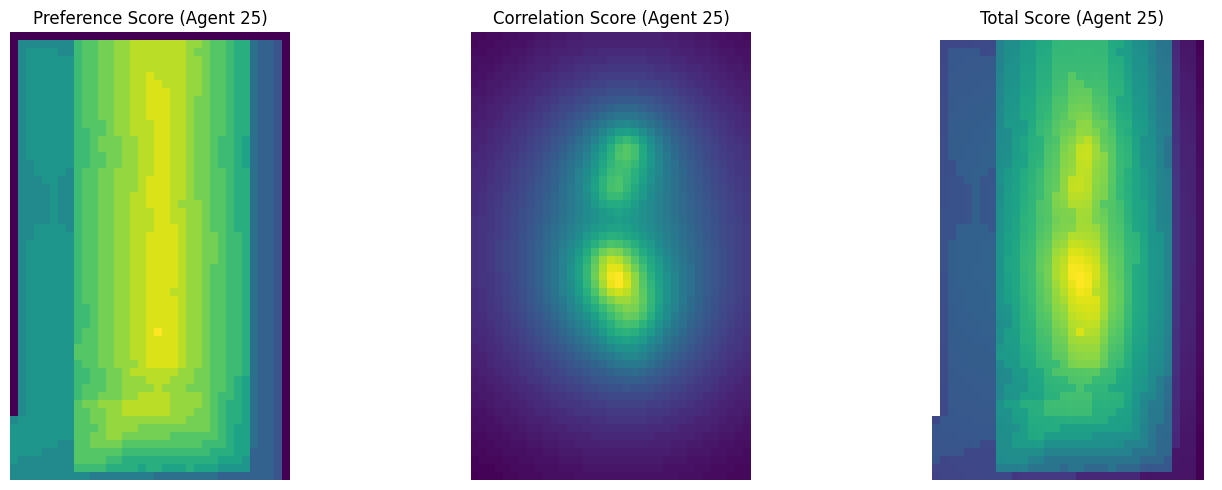

Agent 25:
Best location: (30, 18, 16)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




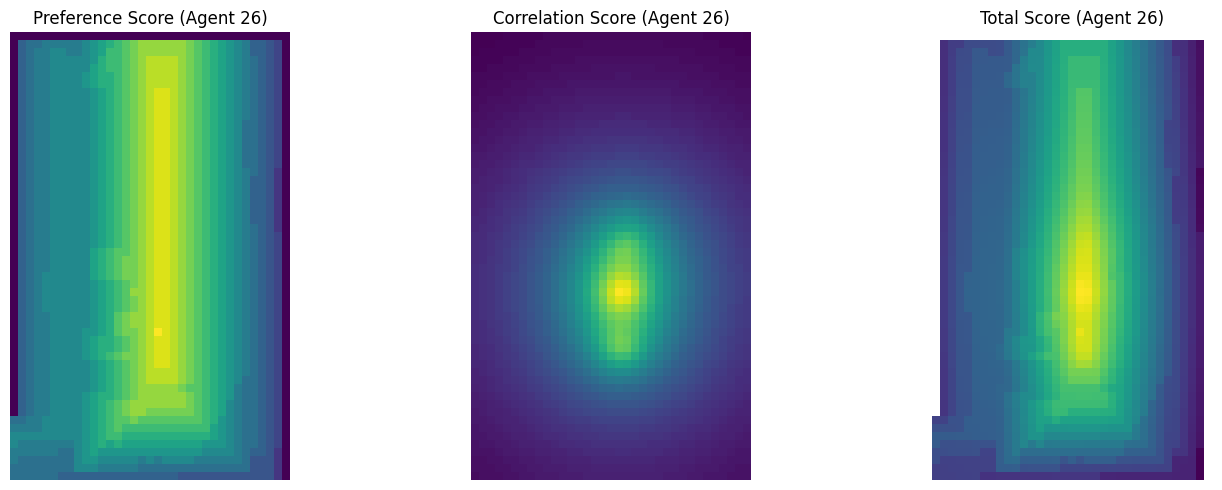

Agent 26:
Best location: (32, 18, 9)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




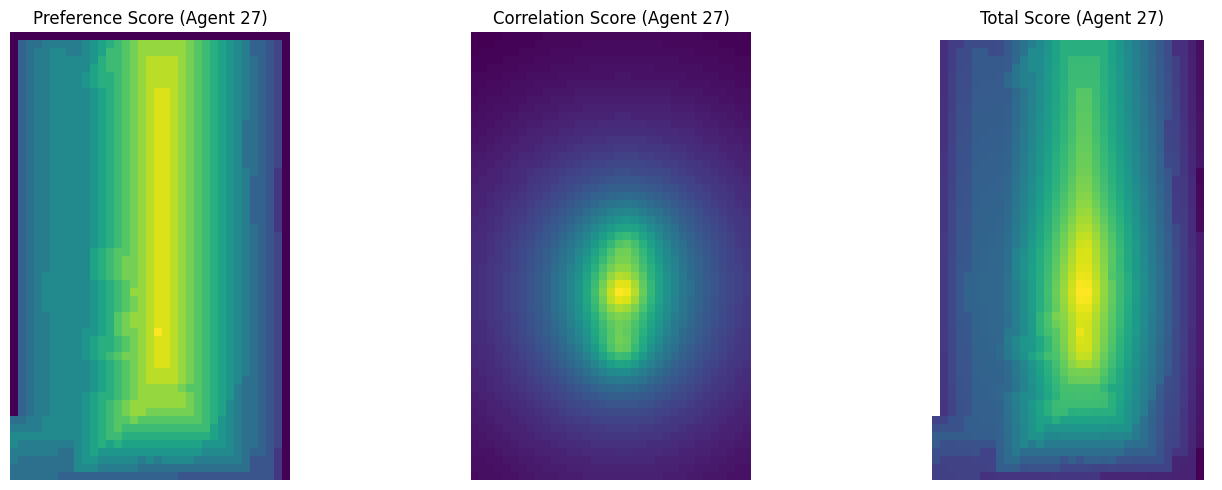

Agent 27:
Best location: (32, 18, 10)
Preference score at best location: 0.9500
Correlation score at best location: 0.9900
Total score at best location: 1.9470




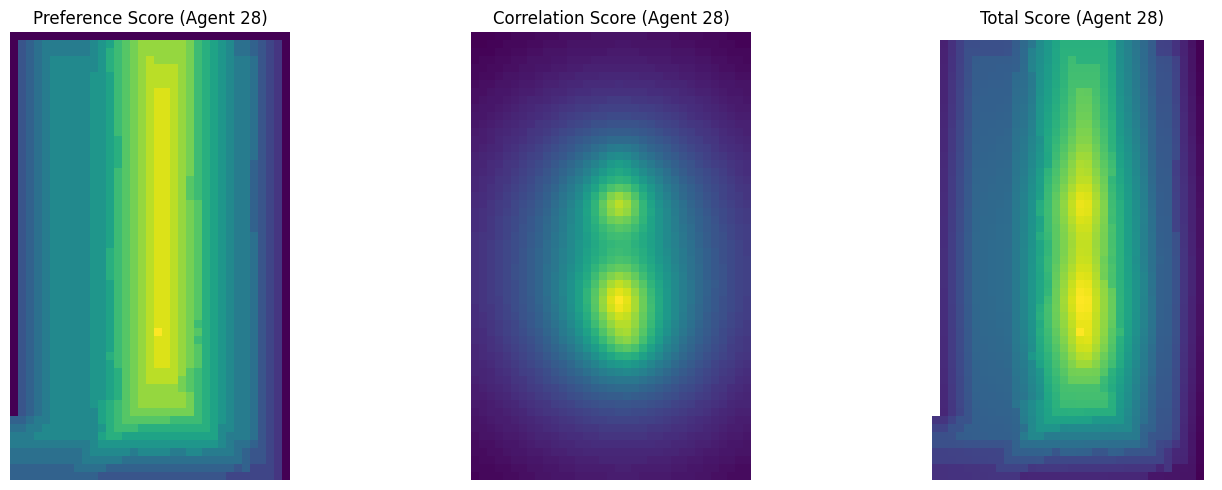

Agent 28:
Best location: (33, 18, 10)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




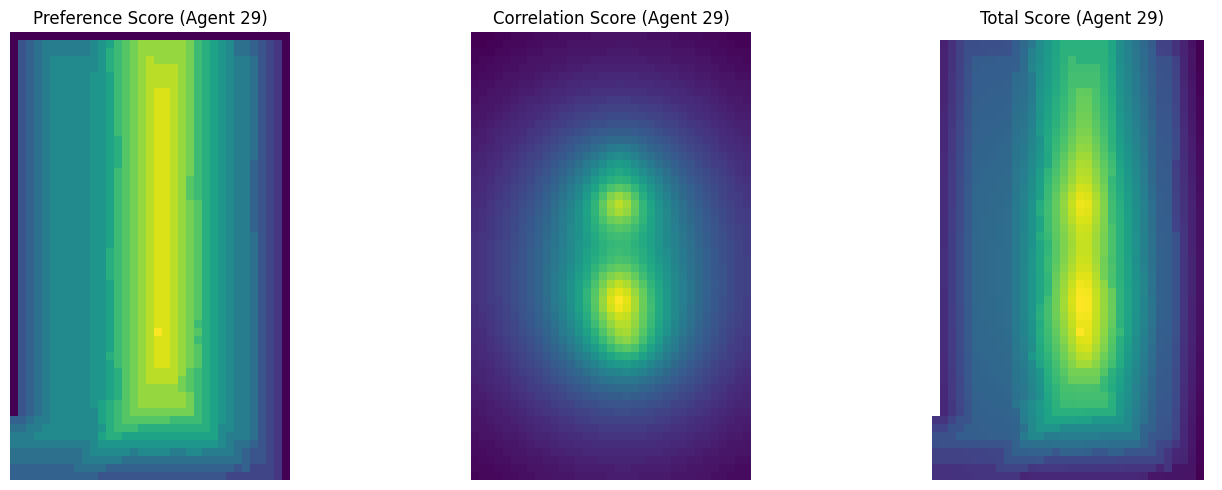

Agent 29:
Best location: (33, 18, 9)
Preference score at best location: 0.9500
Correlation score at best location: 0.9900
Total score at best location: 1.9470




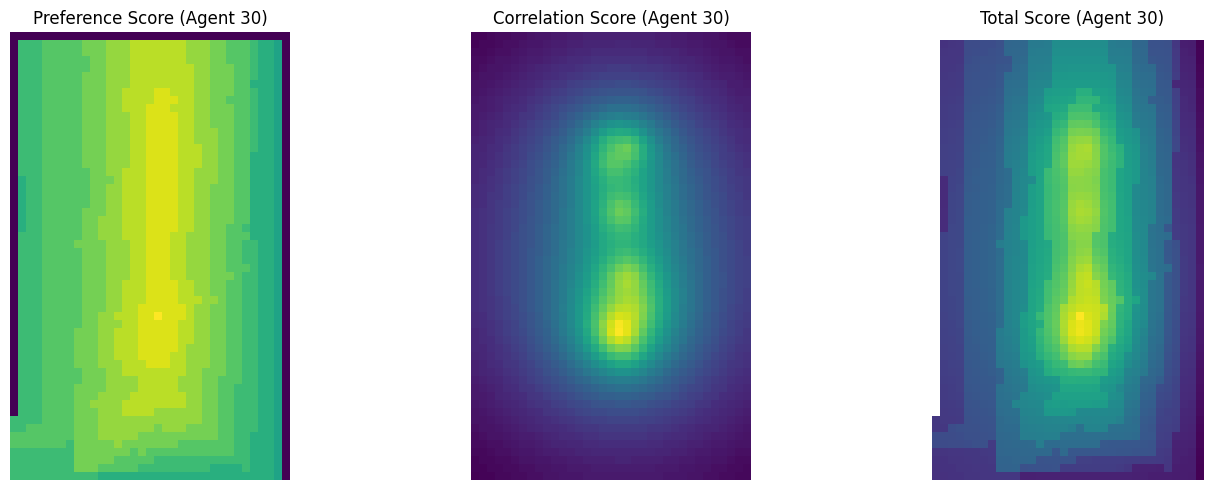

Agent 30:
Best location: (35, 18, 5)
Preference score at best location: 1.0000
Correlation score at best location: 0.8900
Total score at best location: 1.9670




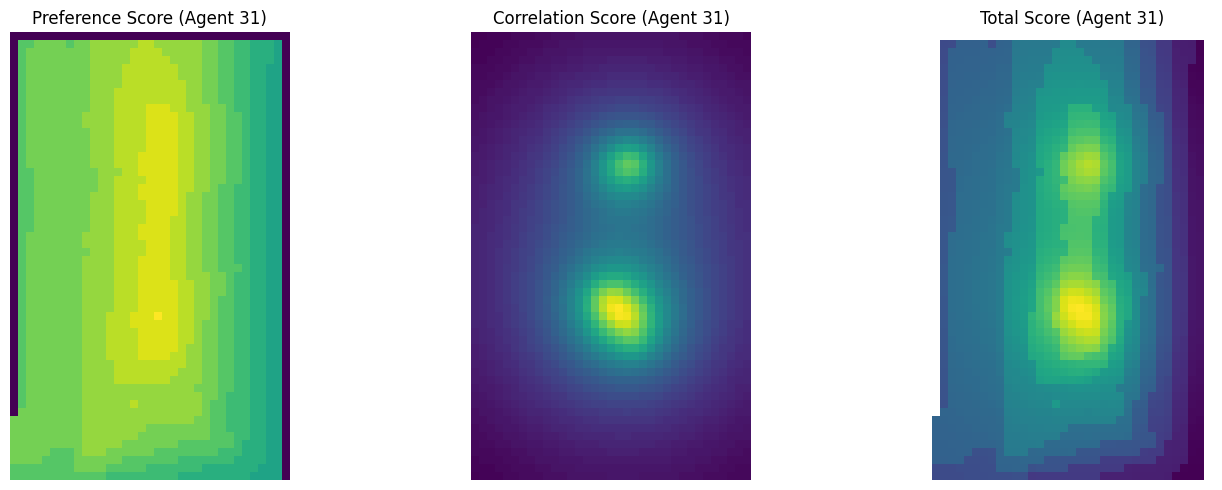

Agent 31:
Best location: (34, 18, 7)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




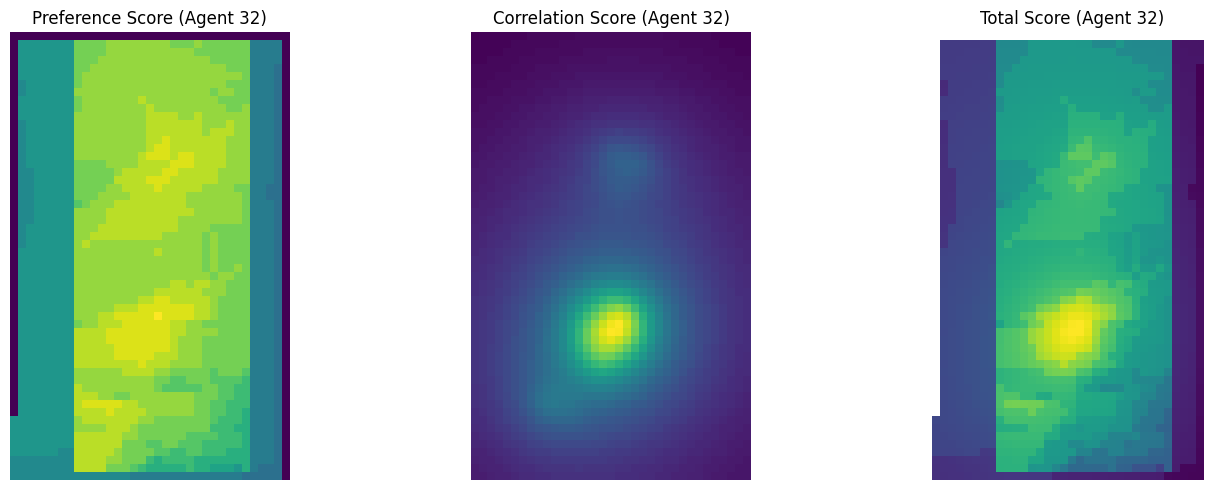

Agent 32:
Best location: (36, 18, 5)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




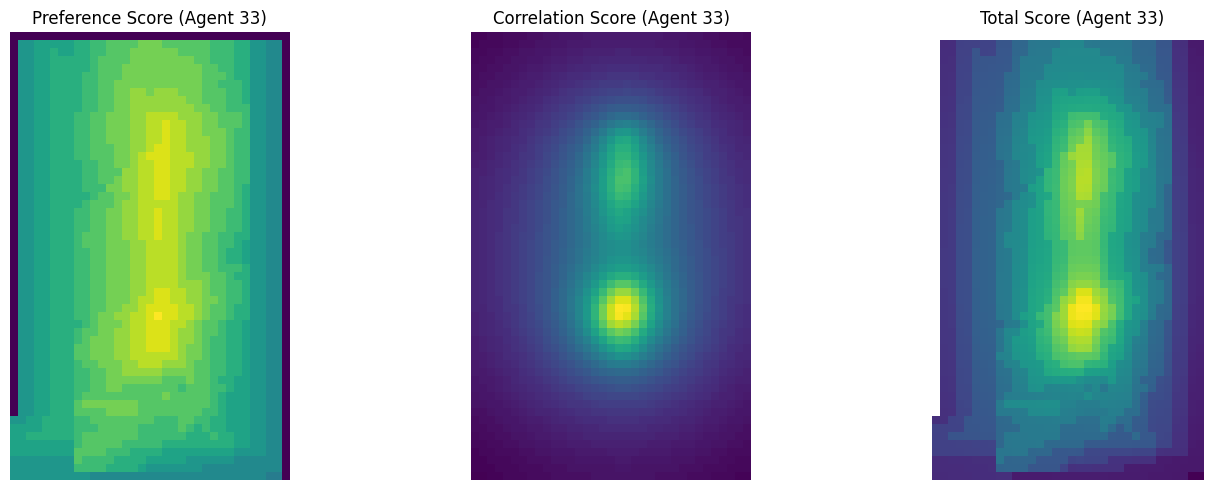

Agent 33:
Best location: (34, 18, 5)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




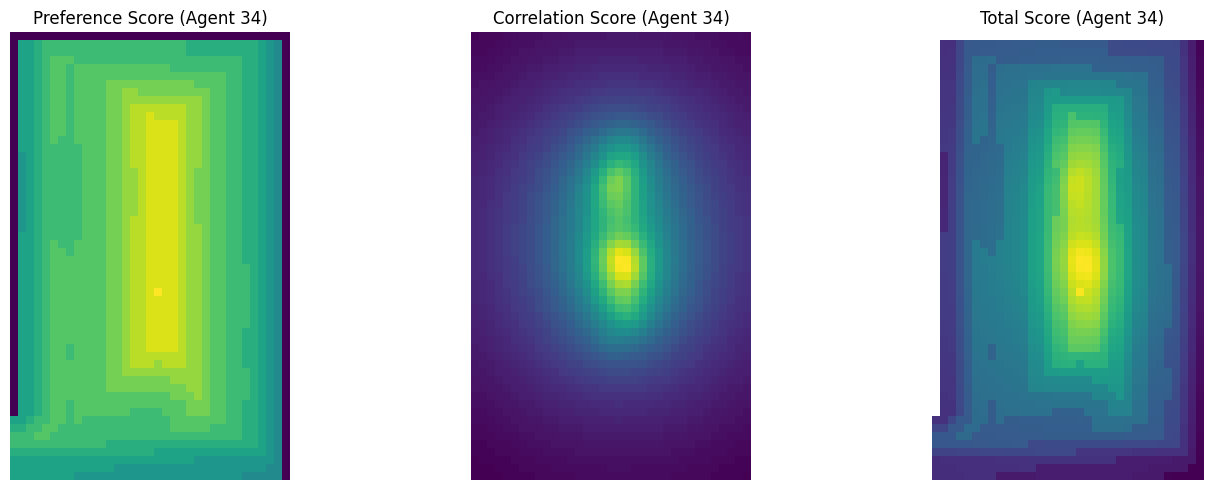

Agent 34:
Best location: (28, 18, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




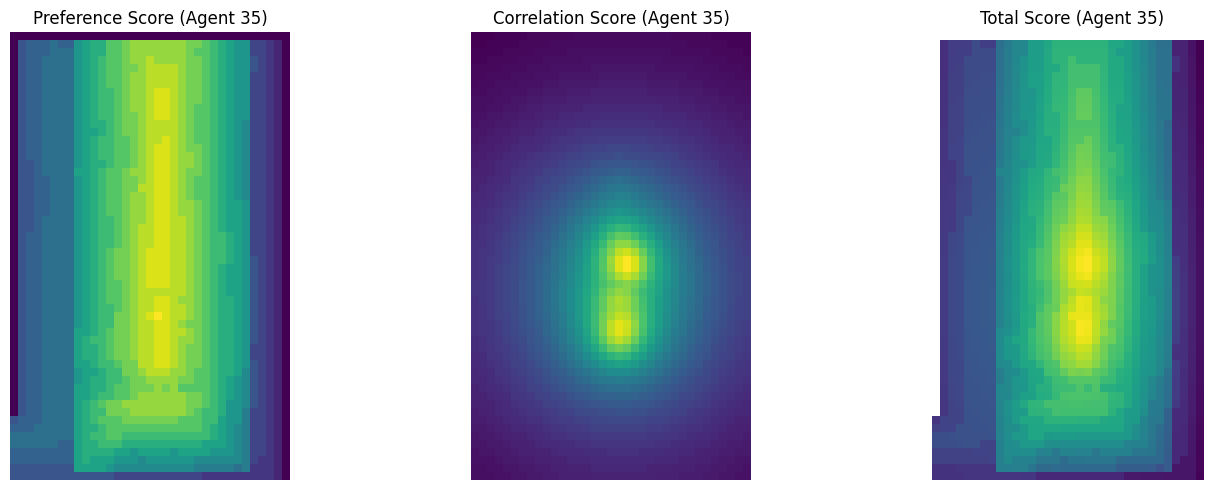

Agent 35:
Best location: (28, 19, 16)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




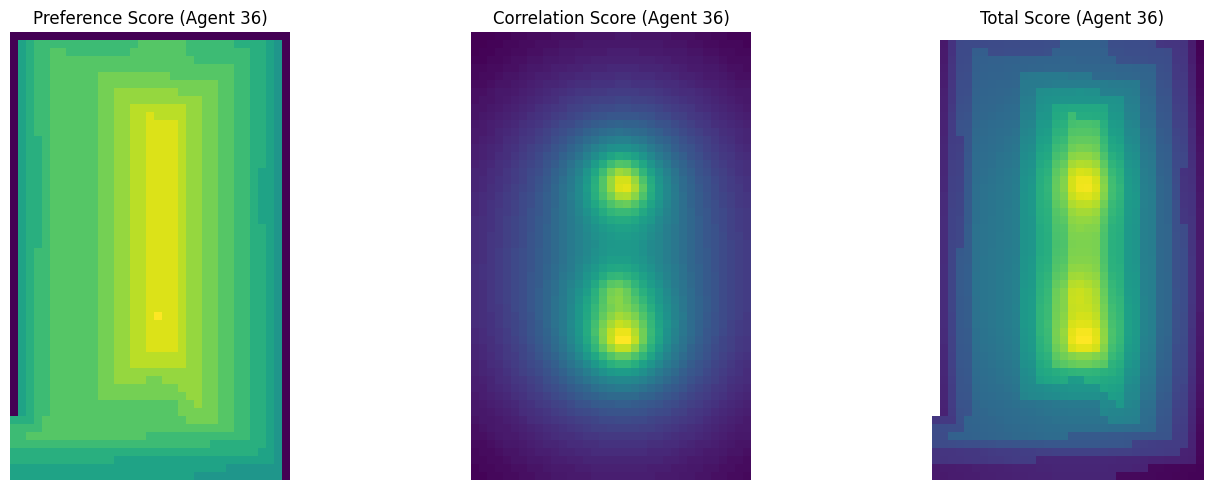

Agent 36:
Best location: (38, 18, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




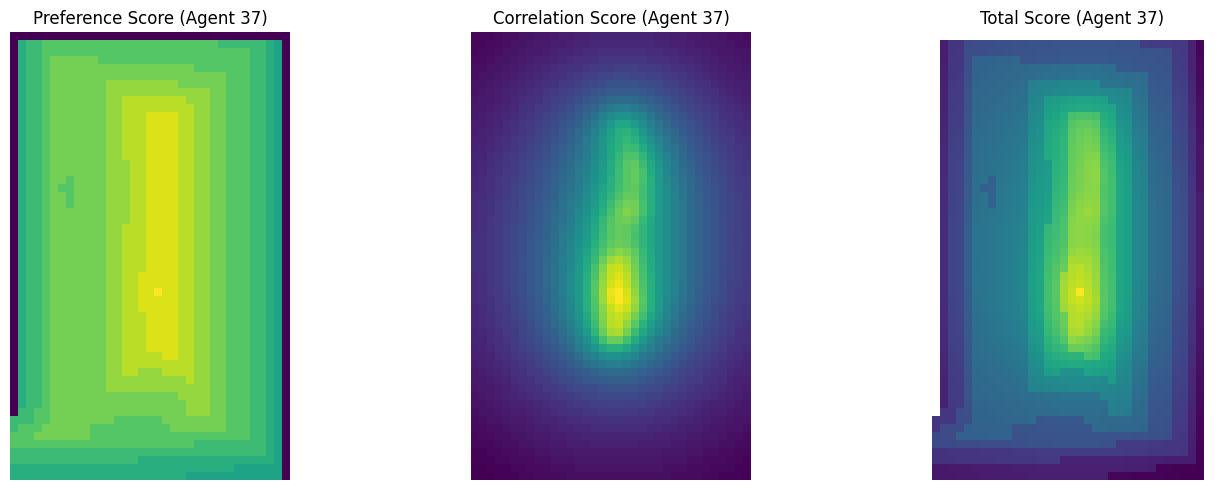

Agent 37:
Best location: (32, 18, 0)
Preference score at best location: 1.0000
Correlation score at best location: 1.0000
Total score at best location: 2.0000




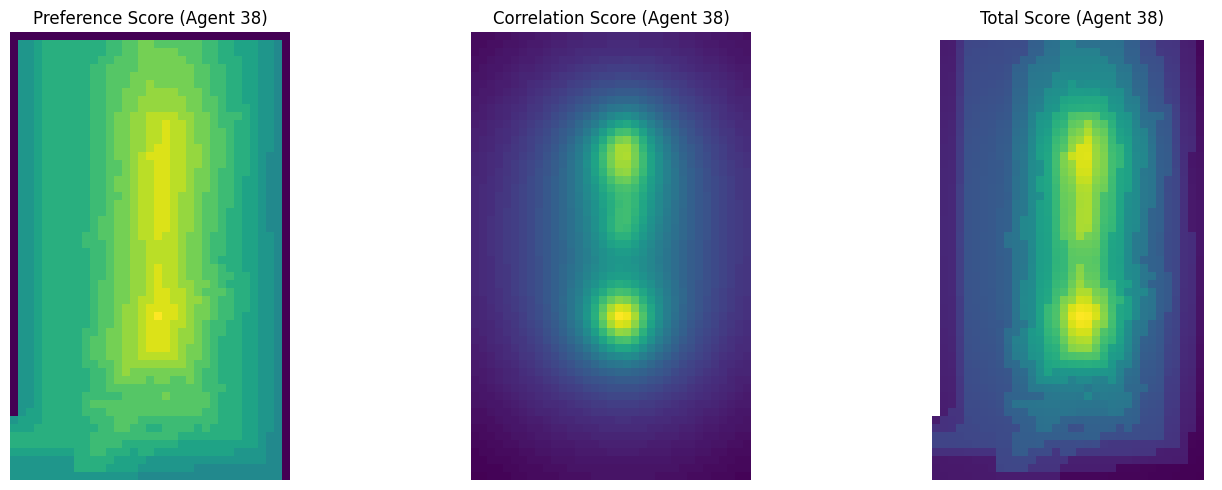

Agent 38:
Best location: (35, 18, 6)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




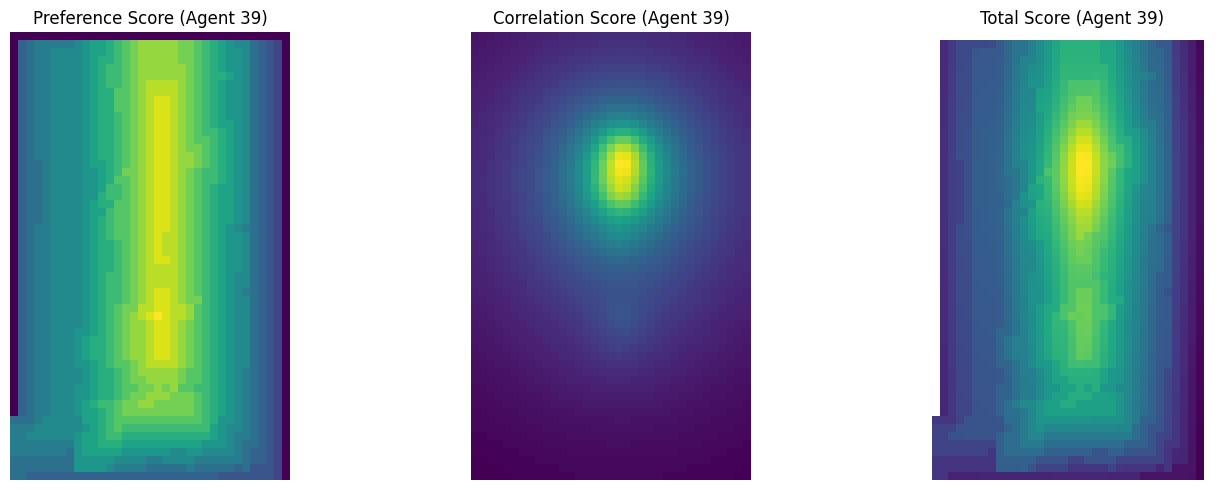

Agent 39:
Best location: (16, 18, 7)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




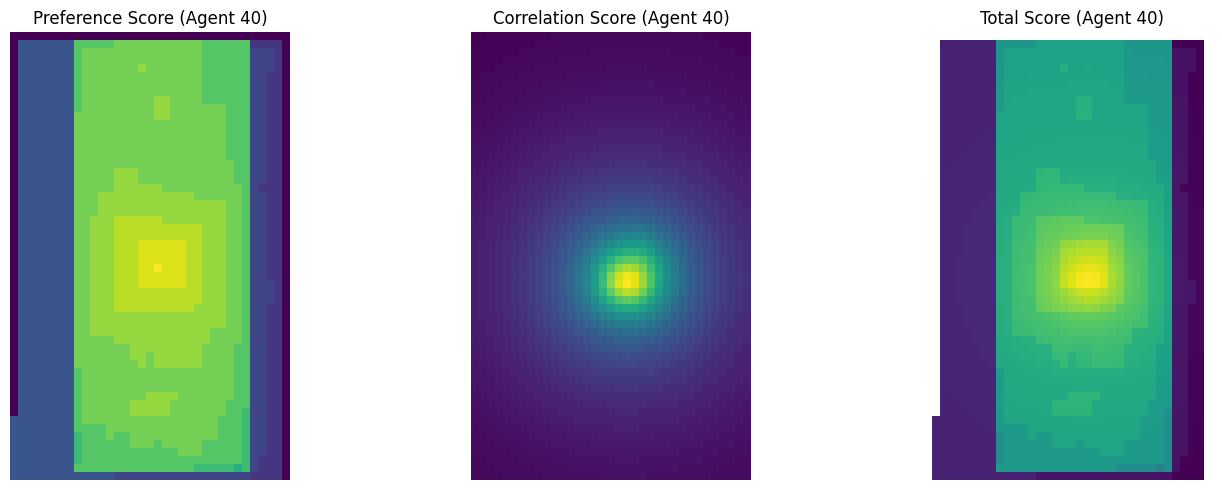

Agent 40:
Best location: (31, 19, 21)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




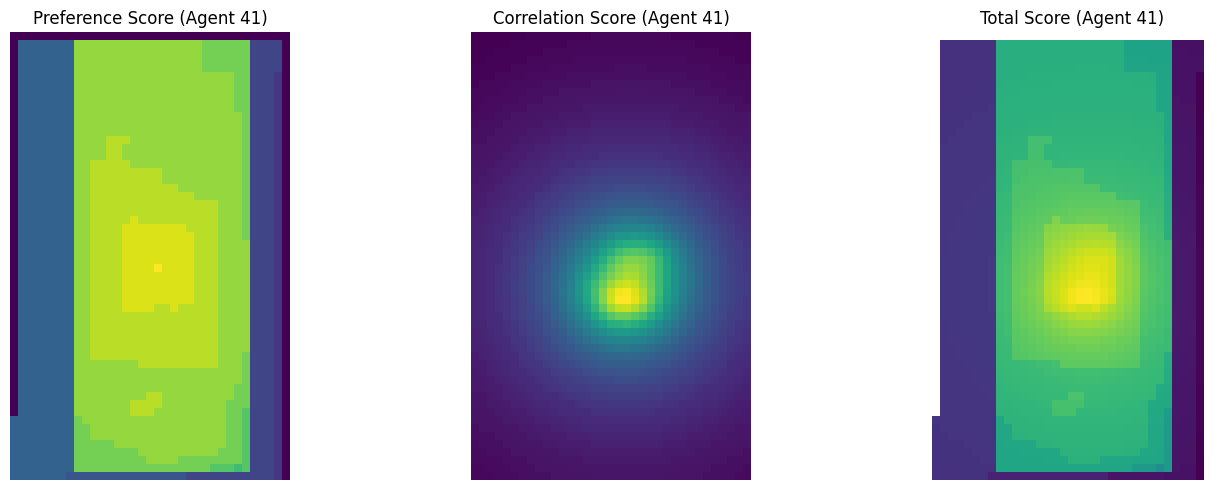

Agent 41:
Best location: (33, 18, 20)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




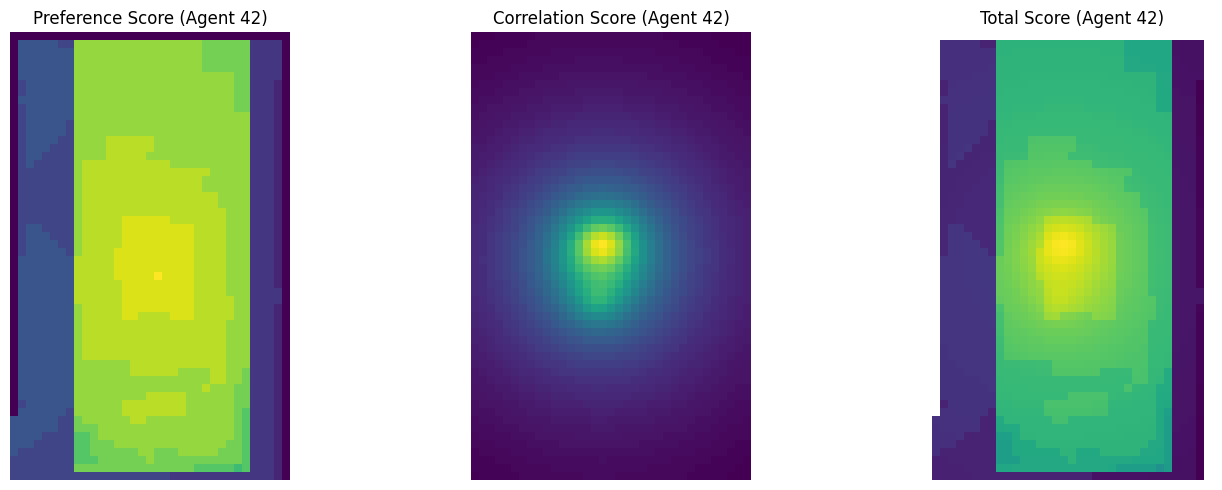

Agent 42:
Best location: (26, 16, 20)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




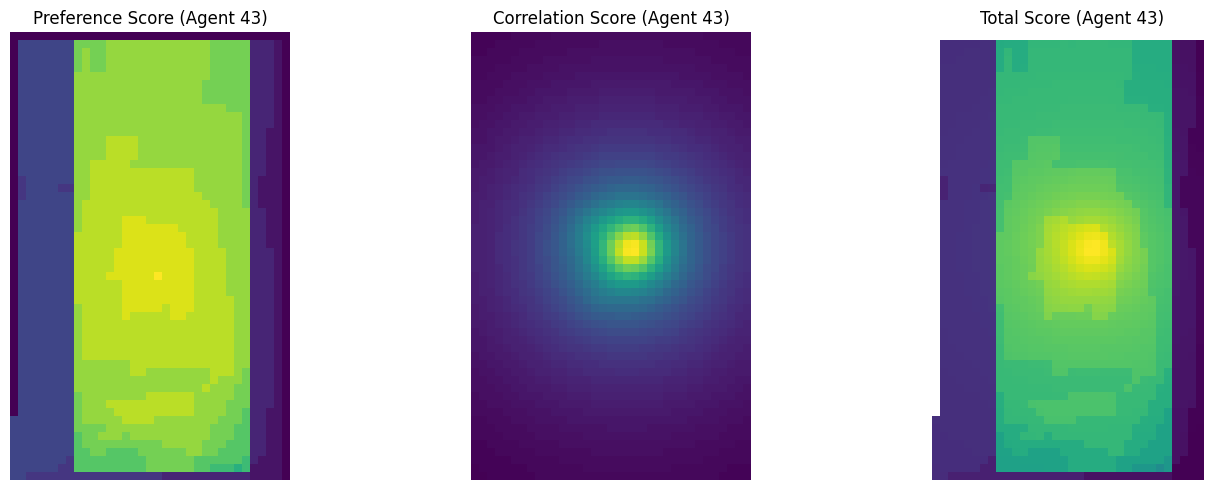

Agent 43:
Best location: (27, 20, 19)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




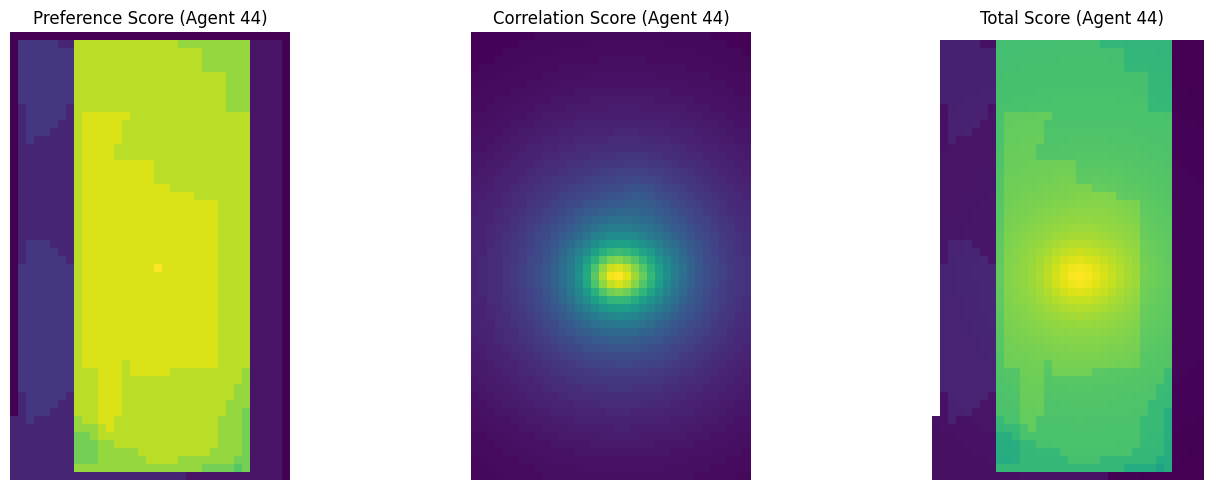

Agent 44:
Best location: (30, 18, 20)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




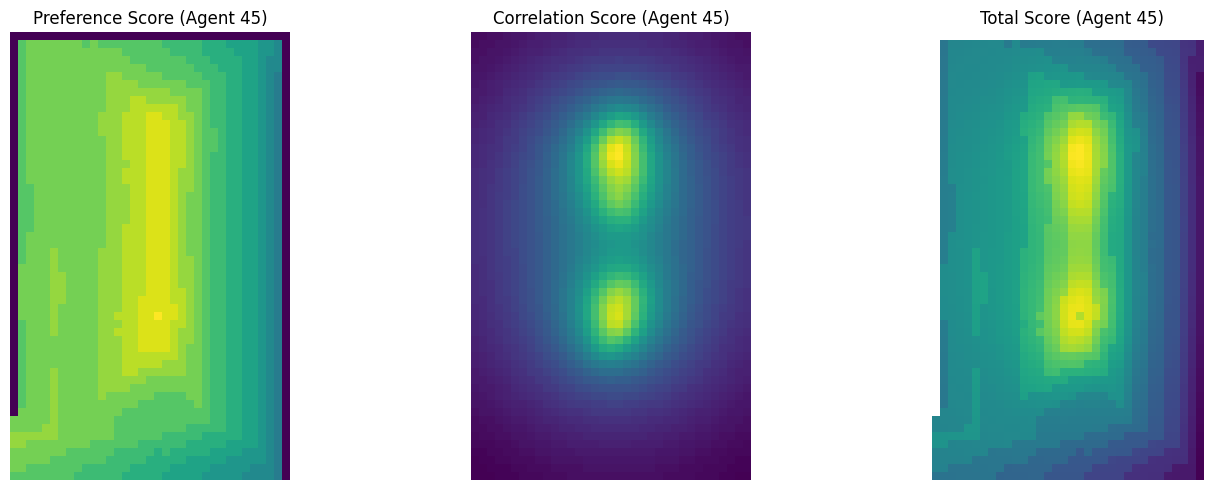

Agent 45:
Best location: (15, 18, 6)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




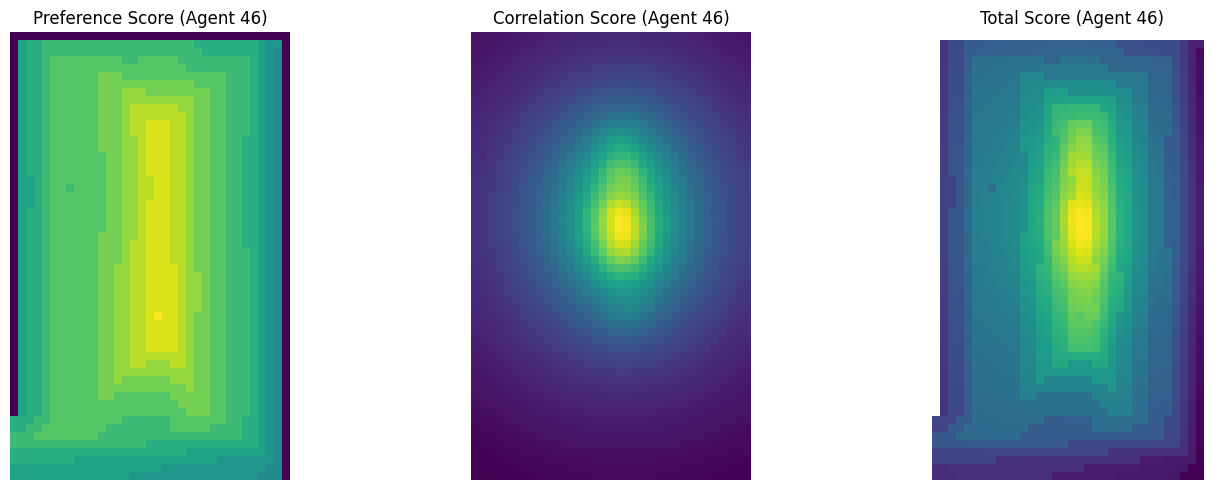

Agent 46:
Best location: (23, 18, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




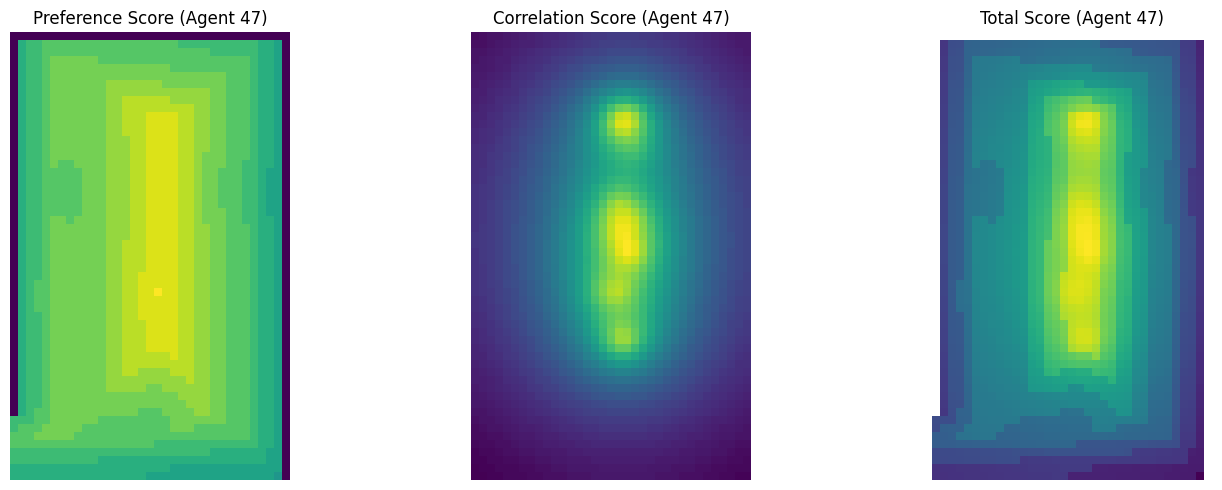

Agent 47:
Best location: (26, 19, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




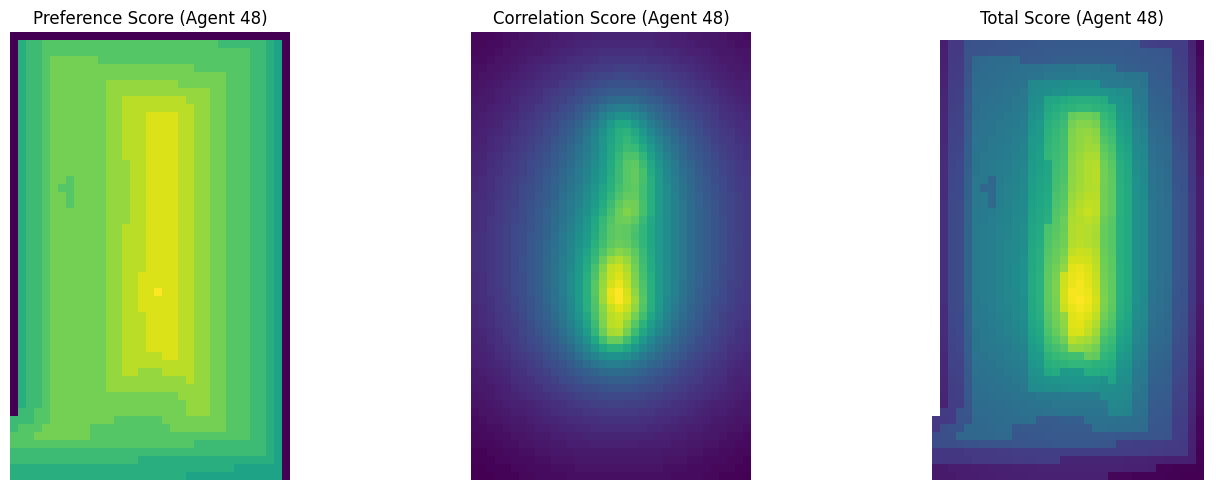

Agent 48:
Best location: (33, 18, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




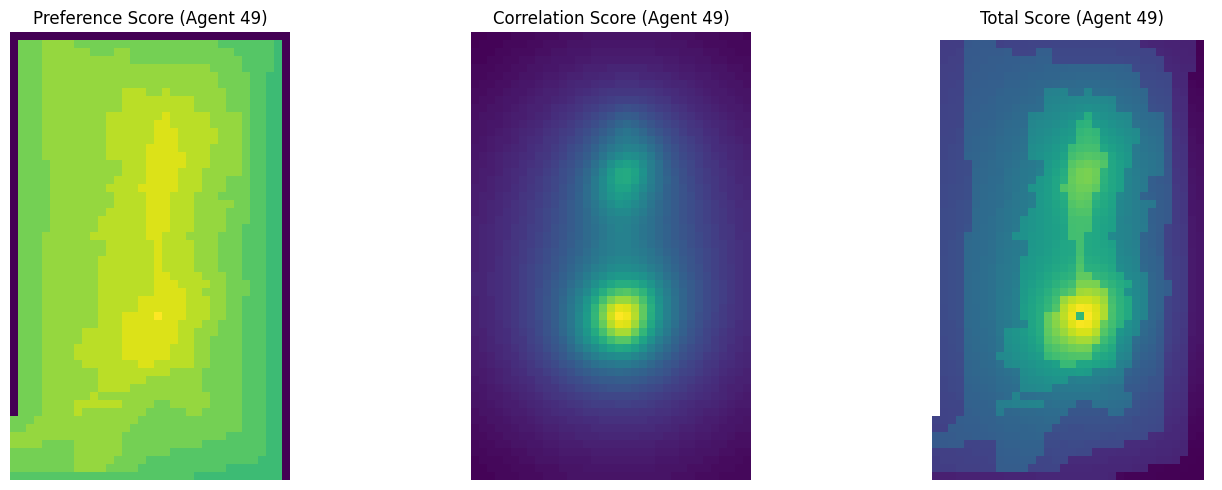

Agent 49:
Best location: (35, 19, 5)
Preference score at best location: 0.9500
Correlation score at best location: 0.9800
Total score at best location: 1.9440




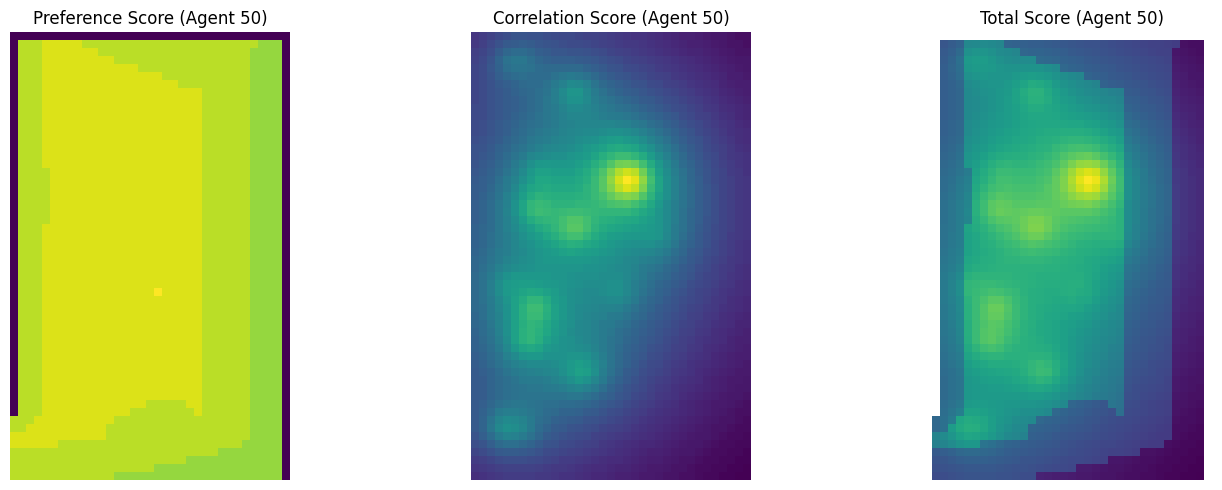

Agent 50:
Best location: (18, 19, 0)
Preference score at best location: 0.9500
Correlation score at best location: 1.0000
Total score at best location: 1.9500




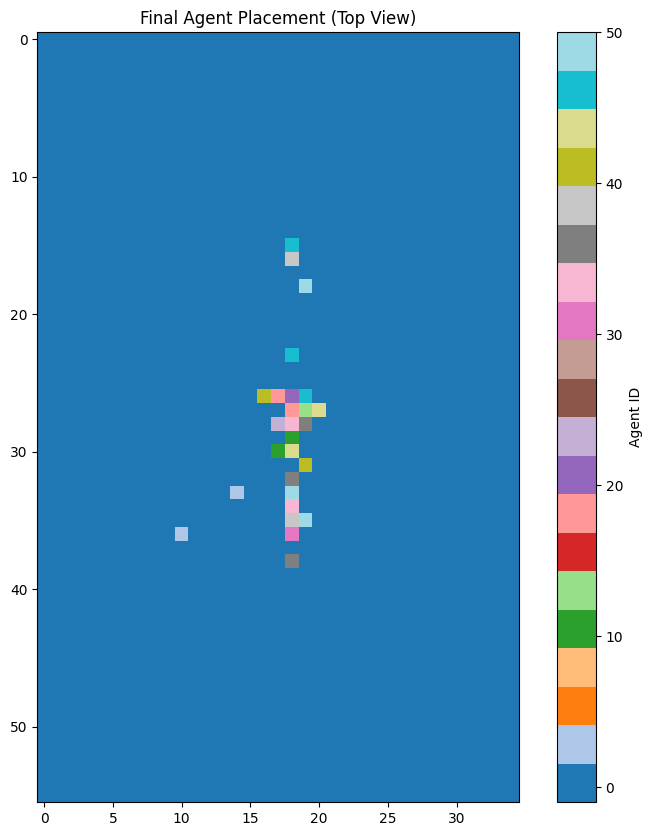

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

agn_num = len(program_prefs)
occ_lattice = avail_lattice * 0 - 1
init_avail_lattice = np.copy(avail_lattice)

def calculate_pref_score(a_id):
    pref_lattice = np.zeros_like(avail_lattice, dtype=float)
    for f, w in program_prefs.iloc[a_id].items():
        pref_lattice += fields[f] * w
    return pref_lattice / sum(program_prefs.iloc[a_id])

def calculate_corr_score(a_id, placed_agents, top_locations):
    corr_lattice = np.zeros_like(avail_lattice, dtype=float)
    if placed_agents:
        x, y, z = np.meshgrid(np.arange(avail_lattice.shape[0]),
                              np.arange(avail_lattice.shape[1]),
                              np.arange(avail_lattice.shape[2]),
                              indexing='ij')
        for loc in top_locations:
            for other_agent, other_loc in placed_agents:
                correlation = program_mtx.iloc[a_id, other_agent]
                distances = np.sqrt((x - loc[0])**2 + (y - loc[1])**2 + (z - loc[2])**2)
                corr_lattice += correlation / (distances + 1)
        corr_lattice /= len(placed_agents) * len(top_locations)
    return corr_lattice


def voxelize(lattice, num_levels=20):
    min_val, max_val = lattice.min(), lattice.max()
    levels = np.linspace(min_val, max_val, num_levels)
    return np.digitize(lattice, levels) / num_levels

def find_best_location(a_id, placed_agents):
    # Calculate and voxelize preference score
    pref_lattice = calculate_pref_score(a_id)
    pref_lattice = voxelize(pref_lattice, num_levels=20)
    
    # Find top 30 locations based on preference score
    top_30_indices = np.argpartition(pref_lattice.flatten(), -30)[-30:]
    top_30_locations = list(map(tuple, np.array(np.unravel_index(top_30_indices, pref_lattice.shape)).T))
    
    # Calculate correlation score
    corr_lattice = calculate_corr_score(a_id, placed_agents, top_30_locations)
    
    if placed_agents:
        # Spread correlation scores to nearby locations
        corr_lattice = gaussian_filter(corr_lattice, sigma=1)
    
    # Normalize correlation scores to [0, 1] range
    if corr_lattice.max() > corr_lattice.min():
        corr_lattice = (corr_lattice - corr_lattice.min()) / (corr_lattice.max() - corr_lattice.min())
    else:
        corr_lattice = np.zeros_like(corr_lattice)    

    # Round correlation scores
    corr_lattice = np.round(corr_lattice, 2)
    
    # Calculate total score with weights
    total_score = 0.7 + pref_lattice + 0.3 * corr_lattice
    total_score[init_avail_lattice == 0] = -np.inf
    best_location = np.unravel_index(np.argmax(total_score), total_score.shape)
    
    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.max(pref_lattice, axis=2), cmap='viridis')
    axs[0].set_title(f'Preference Score (Agent {a_id})')
    axs[1].imshow(np.max(corr_lattice, axis=2), cmap='viridis')
    axs[1].set_title(f'Correlation Score (Agent {a_id})')
    axs[2].imshow(np.max(total_score, axis=2), cmap='viridis')
    axs[2].set_title(f'Total Score (Agent {a_id})')
    
    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Agent {a_id}:")
    print(f"Best location: {best_location}")
    print(f"Preference score at best location: {pref_lattice[best_location]:.4f}")
    print(f"Correlation score at best location: {corr_lattice[best_location]:.4f}")
    print(f"Total score at best location: {total_score[best_location]:.4f}")
    print("\n")
    
    return best_location, total_score[best_location]
# 에이전트 배치
agn_locs = []
for a_id in range(agn_num):
    best_location, best_score = find_best_location(a_id, agn_locs)
    agn_locs.append((a_id, best_location))
    init_avail_lattice[best_location] = 0
    occ_lattice[best_location] = a_id

# 최종 배치 시각화
plt.figure(figsize=(10, 10))
plt.imshow(np.max(occ_lattice, axis=2), cmap='tab20')
plt.colorbar(label='Agent ID')
plt.title('Final Agentnt ID')
plt.title('Final Agent Placement (Top View)')
plt.show()

In [15]:
print(agn_locs)

[(0, (39, 8, 5)), (1, (36, 11, 5)), (2, (36, 10, 5)), (3, (33, 14, 6)), (4, (35, 18, 7)), (5, (30, 18, 18)), (6, (35, 18, 8)), (7, (29, 18, 23)), (8, (28, 18, 18)), (9, (28, 18, 22)), (10, (29, 18, 18)), (11, (30, 17, 21)), (12, (27, 19, 21)), (13, (28, 19, 20)), (14, (28, 19, 21)), (15, (26, 18, 21)), (16, (26, 17, 21)), (17, (26, 18, 22)), (18, (26, 17, 22)), (19, (27, 18, 21)), (20, (26, 18, 20)), (21, (31, 19, 9)), (22, (31, 19, 8)), (23, (28, 17, 23)), (24, (35, 18, 12)), (25, (30, 18, 16)), (26, (32, 18, 9)), (27, (32, 18, 10)), (28, (33, 18, 10)), (29, (33, 18, 9)), (30, (35, 18, 5)), (31, (34, 18, 7)), (32, (36, 18, 5)), (33, (34, 18, 5)), (34, (28, 18, 0)), (35, (28, 19, 16)), (36, (38, 18, 0)), (37, (32, 18, 0)), (38, (35, 18, 6)), (39, (16, 18, 7)), (40, (31, 19, 21)), (41, (33, 18, 20)), (42, (26, 16, 20)), (43, (27, 20, 19)), (44, (30, 18, 20)), (45, (15, 18, 6)), (46, (23, 18, 0)), (47, (26, 19, 0)), (48, (33, 18, 0)), (49, (35, 19, 5)), (50, (18, 19, 0))]


In [16]:
import csv
def save_agn_locs_to_csv(agn_locs, output_path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write the agn_locs list to a CSV file
    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Agent ID', 'X', 'Y', 'Z'])  # Header
        for agent_id, location in agn_locs:
            writer.writerow([agent_id, location[0], location[1], location[2]])
    
    print(f"Agent locations saved to {output_path}")

# Usage example
csv_path = os.path.relpath('original_lattice/starting_locs.csv')
save_agn_locs_to_csv(agn_locs, csv_path)

# Print the agn_locs list
print("agn_locs:")
for item in agn_locs:
    print(item)


Agent locations saved to original_lattice\starting_locs.csv
agn_locs:
(0, (39, 8, 5))
(1, (36, 11, 5))
(2, (36, 10, 5))
(3, (33, 14, 6))
(4, (35, 18, 7))
(5, (30, 18, 18))
(6, (35, 18, 8))
(7, (29, 18, 23))
(8, (28, 18, 18))
(9, (28, 18, 22))
(10, (29, 18, 18))
(11, (30, 17, 21))
(12, (27, 19, 21))
(13, (28, 19, 20))
(14, (28, 19, 21))
(15, (26, 18, 21))
(16, (26, 17, 21))
(17, (26, 18, 22))
(18, (26, 17, 22))
(19, (27, 18, 21))
(20, (26, 18, 20))
(21, (31, 19, 9))
(22, (31, 19, 8))
(23, (28, 17, 23))
(24, (35, 18, 12))
(25, (30, 18, 16))
(26, (32, 18, 9))
(27, (32, 18, 10))
(28, (33, 18, 10))
(29, (33, 18, 9))
(30, (35, 18, 5))
(31, (34, 18, 7))
(32, (36, 18, 5))
(33, (34, 18, 5))
(34, (28, 18, 0))
(35, (28, 19, 16))
(36, (38, 18, 0))
(37, (32, 18, 0))
(38, (35, 18, 6))
(39, (16, 18, 7))
(40, (31, 19, 21))
(41, (33, 18, 20))
(42, (26, 16, 20))
(43, (27, 20, 19))
(44, (30, 18, 20))
(45, (15, 18, 6))
(46, (23, 18, 0))
(47, (26, 19, 0))
(48, (33, 18, 0))
(49, (35, 19, 5))
(50, (18, 19, 0

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

# np.random.seed(42)

# agn_num = len(program_prefs)
# occ_lattice = avail_lattice * 0 - 1
# init_avail_lattice = np.copy(avail_lattice)
# # 
# def calculate_pref_score(a_id):
#     pref_lattice = np.zeros_like(avail_lattice, dtype=float)
#     for f, w in program_prefs.iloc[a_id].items():
#         pref_lattice += fields[f] * w
#     return pref_lattice / sum(program_prefs.iloc[a_id])

# def calculate_corr_score(a_id, placed_agents, locations):
#     corr_lattice = np.zeros_like(avail_lattice, dtype=float)
#     if placed_agents:
#         x, y, z = np.meshgrid(np.arange(avail_lattice.shape[0]),
#                               np.arange(avail_lattice.shape[1]),
#                               np.arange(avail_lattice.shape[2]),
#                               indexing='ij')
#         for loc in locations:
#             for other_agent, other_loc in placed_agents:
#                 correlation = program_mtx.iloc[a_id, other_agent]
#                 distances = np.sqrt((x - loc[0])**2 + (y - loc[1])**2 + (z - loc[2])**2)
#                 corr_lattice += correlation / (distances + 1)
#         corr_lattice /= len(placed_agents)
#     return corr_lattice

# def find_best_location(a_id, placed_agents):
#     pref_lattice = calculate_pref_score(a_id)
#     pref_lattice[init_avail_lattice == 0] = -np.inf
    
#     # 상위 30개 위치 선택
#     top_30_indices = np.argpartition(pref_lattice.flatten(), -30)[-30:]
#     top_30_locations = np.array(np.unravel_index(top_30_indices, pref_lattice.shape)).T
    
#     # 선택된 위치에 대해 상관관계 점수 계산
#     corr_lattice = calculate_corr_score(a_id, placed_agents, top_30_locations)
    
#     # 최종 점수 계산
#     total_score = pref_lattice + corr_lattice
#     total_score[init_avail_lattice == 0] = -np.inf
#     best_location = np.unravel_index(np.argmax(total_score), total_score.shape)
    
#     # 결과 시각화
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     axs[0].imshow(np.max(pref_lattice, axis=2), cmap='viridis')
#     axs[0].set_title(f'Preference Score (Agent {a_id})')
#     axs[1].imshow(np.max(corr_lattice, axis=2), cmap='viridis')
#     axs[1].set_title(f'Correlation Score (Agent {a_id})')
#     axs[2].imshow(np.max(total_score, axis=2), cmap='viridis')
#     axs[2].set_title(f'Total Score (Agent {a_id})')
#     plt.show()
    
#     print(f"Agent {a_id}:")
#     print(f"Best location: {best_location}")
#     print(f"Preference score at best location: {pref_lattice[best_location]:.4f}")
#     print(f"Correlation score at best location: {corr_lattice[best_location]:.4f}")
#     print(f"Total score at best location: {total_score[best_location]:.4f}")
#     print("\n")
    
#     return best_location, total_score[best_location]

# # 에이전트 배치
# agn_locs = []
# for a_id in range(agn_num):
#     best_location, best_score = find_best_location(a_id, agn_locs)
#     agn_locs.append((a_id, best_location))
#     init_avail_lattice[best_location] = 0
#     occ_lattice[best_location] = a_id

# # 최종 결과 출력
# print("Final agent locations:")
# for i, (agent, loc) in enumerate(agn_locs):
#     print(f"Agent {agent}: Location = {loc}")

# # 최종 배치 시각화
# plt.figure(figsize=(10, 10))
# plt.imshow(np.max(occ_lattice, axis=2), cmap='tab20')
# plt.colorbar(label='Agent ID')
# plt.title('Final Agent Placement (Top View)')
# plt.show()


In [18]:
from matplotlib.colors import ListedColormap

# PyVista 플로터 초기화
p = pv.Plotter(notebook=True)

# 그리드 설정
#base_lattice = frames[0]
grid = pv.ImageData()
grid.dimensions = np.array(occ_lattice.shape) + 1
# grid.origin과 grid.spacing 설정에 avail_lattice의 속성 사용
grid.origin = avail_lattice.minbound - avail_lattice.unit * 0.5
grid.spacing = avail_lattice.unit

# 데이터 할당
grid.cell_data["Agents"] = occ_lattice.flatten(order="F").astype(int)

# 필터링
agn_num = len(program_prefs)
threshed = grid.threshold([-0.1, agn_num - 0.9])

# 초기 컬러맵 설정
initial_colors = ["#808080" if i == 0 else "#FF0000" for i in range(len(program_prefs))]
custom_cmap = ListedColormap(initial_colors)

# 스칼라 바 설정
annotations = {i: name for i, name in enumerate(space_list.values())}
sargs = {
    "shadow": True,
    "n_labels": len(program_prefs),
    "italic": False,
    "fmt": " %.0f",
    "font_family": "arial",
    "height": 1,
    "vertical": True,
    "title_font_size": 10,
    "label_font_size": 6
}

# 메시 추가
opacity_map = np.full(threshed.n_cells, 0.1)  # 초기 투명도 설정
threshed.cell_data['opacity'] = opacity_map
mesh = p.add_mesh(threshed, scalars='opacity', cmap=custom_cmap, show_scalar_bar=True, scalar_bar_args=sargs, show_edges=True, opacity=1)

# 텍스트 추가
text_actor = p.add_text("Selected Program: None", position='upper_right', font_size=12, color='black')

# 슬라이더 콜백 함수
def slider_callback(value):
    selected_program = int(value)
    mask = threshed.cell_data['Agents'] == selected_program
    opacity = np.full(threshed.n_cells, 0.1)  # 기본 투명도 설정
    opacity[mask] = 1.0  # 선택된 프로그램에 높은 투명도 부여

    # 투명도 업데이트
    threshed.cell_data['opacity'] = opacity
    
    # 텍스트 업데이트
    text_actor.SetText(0, f"Selected Program: {annotations[selected_program]}")
    p.render()

# 슬라이더 위젯 추가
p.add_slider_widget(slider_callback, [0, len(program_prefs) - 1], value=0, title='Program Index')
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=True, annotations=annotations, scalar_bar_args=sargs, cmap=custom_cmap)

p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa', opacity=0.3)
p.add_mesh(entrance_pc, color='red', opacity=1.0)
# 시각화 표시
p.show(jupyter_backend="trame", return_viewer=True)


Widget(value='<iframe src="http://localhost:54704/index.html?ui=P_0x25c6348d510_1&reconnect=auto" class="pyvis…